Ravi, Xiong, and Howard<br>
CS 6140: Machine Learning<br>
Northeastern University<br>
March 27, 2023<br>

Comment on team dynamic: We all feel that we contributed roughly equally, with each member contributing more in certain areas. It was a good learning experience to collaborate.

## HW 6: Comprehensive Supervised Learning

### 0. Imports and data clean up

##### 0.1 Import libraries

In [307]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, precision_score, recall_score, f1_score, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor

# Deliver with style
plt.style.use('dark_background')
import warnings
warnings.filterwarnings('ignore') 
sns.set(rc={'figure.figsize':(11,8)})
pd.options.display.float_format = '{:.2f}'.format

##### 0.2 Read the data

In [308]:
# Read data from csv
df19 = pd.read_csv('data/brfss19.csv', usecols = range(1, 250))
df21 = pd.read_csv('data/brfss21.csv', usecols = range(1, 250))

# Shape of the dataframes
print(df19.shape)
print(df21.shape)

(418268, 249)
(438693, 249)


In [309]:
df19.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,_FRUTSU1,_VEGESU1,_FRTLT1A,_VEGLT1A,_FRT16A,_VEG23A,_FRUITE1,_VEGETE1,_FLSHOT7,_PNEUMO3
0,1,1,1182019,1,18,2019,1100,2019000001,2019000001,1.00,...,200.00,114.00,1,1,1,1,0,0,2.00,1.00
1,1,1,1132019,1,13,2019,1100,2019000002,2019000002,1.00,...,100.00,121.00,1,1,1,1,0,0,1.00,1.00
2,1,1,1182019,1,18,2019,1100,2019000003,2019000003,1.00,...,114.00,164.00,1,1,1,1,0,0,1.00,2.00
3,1,1,1182019,1,18,2019,1200,2019000004,2019000004,1.00,...,NaN,NaN,9,9,1,1,1,1,9.00,9.00
4,1,1,1042019,1,4,2019,1100,2019000005,2019000005,1.00,...,143.00,178.00,1,1,1,1,0,0,2.00,1.00


In [310]:
df21.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,_MISVEG1,_FRTRES1,_VEGRES1,_FRUTSU1,_VEGESU1,_FRTLT1A,_VEGLT1A,_FRT16A,_VEG23A,_FRUITE1
0,1.00,1.00,b'01192021',b'01',b'19',b'2021',1100.00,b'2021000001',2021000001.00,1.00,...,0.00,1.00,1.00,100.00,214.00,1.00,1.00,1.00,1.00,0.00
1,1.00,1.00,b'01212021',b'01',b'21',b'2021',1100.00,b'2021000002',2021000002.00,1.00,...,0.00,1.00,1.00,100.00,128.00,1.00,1.00,1.00,1.00,0.00
2,1.00,1.00,b'01212021',b'01',b'21',b'2021',1100.00,b'2021000003',2021000003.00,1.00,...,0.00,1.00,1.00,100.00,71.00,1.00,2.00,1.00,1.00,0.00
3,1.00,1.00,b'01172021',b'01',b'17',b'2021',1100.00,b'2021000004',2021000004.00,1.00,...,0.00,1.00,1.00,114.00,165.00,1.00,1.00,1.00,1.00,0.00
4,1.00,1.00,b'01152021',b'01',b'15',b'2021',1100.00,b'2021000005',2021000005.00,1.00,...,0.00,1.00,1.00,100.00,258.00,1.00,1.00,1.00,1.00,0.00


##### 0.3 Align the dataframes

In [311]:
# Compare the different column names in the two data frame
(set(df19.columns) | set(df21.columns)) - (set(df19.columns) & set(df21.columns))

{'CHCCOPD2', 'CHCCOPD3', 'INCOME2', 'INCOME3', '_AIDTST4', '_VEGETE1'}

* The dataframes diverge in only two response column names, which are 'CHCCOPD2' and 'CHCCOPD3'.
* Since the two names stand for the same thing, we will rename both of these columns df21['CHCCOPD3'] and df19['CHCCOPD2] as 'COPD'.
* For 'INCOME2' and 'INCOME3' we will also rename and preserve as 'INCOME2'.
* We will drop '_AIDTST4' and '_VEGETE1' entirely.

In [312]:
# Renaming the columns to match each other
df21.rename(columns = {'CHCCOPD3':'COPD'}, inplace = True)
df19.rename(columns = {'CHCCOPD2':'COPD'}, inplace = True)

In [313]:
# Renaming INCOME3 of df21 to INCOME2 to match with df19
df21.rename(columns = {'INCOME3' : 'INCOME2'}, inplace = True)

In [314]:
# Dropping _AIDTST4 and _VEGETE1
df21 = df21.drop('_AIDTST4', axis=1)
df19 = df19.drop('_VEGETE1', axis=1)

In [315]:
# Confirming no issue
print(set(df21.columns) - set(df19.columns))
for column in df21.columns:
    if column not in set(df19.columns):
        print(column)
for column in df19.columns:
    if column not in set(df21.columns):
        print(column)

set()


##### 0.4 Combine the dataframes

In [316]:
# Now the two df has the same column names, we can concat the two df.
df = pd.concat([df19, df21], ignore_index=True, sort=False)
df.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,_VEGRES1,_FRUTSU1,_VEGESU1,_FRTLT1A,_VEGLT1A,_FRT16A,_VEG23A,_FRUITE1,_FLSHOT7,_PNEUMO3
0,1.00,1.00,1182019,1,18,2019,1100.00,2019000001,2019000001.00,1.00,...,1.00,200.00,114.00,1.00,1.00,1.00,1.00,0.00,2.00,1.00
1,1.00,1.00,1132019,1,13,2019,1100.00,2019000002,2019000002.00,1.00,...,1.00,100.00,121.00,1.00,1.00,1.00,1.00,0.00,1.00,1.00
2,1.00,1.00,1182019,1,18,2019,1100.00,2019000003,2019000003.00,1.00,...,1.00,114.00,164.00,1.00,1.00,1.00,1.00,0.00,1.00,2.00
3,1.00,1.00,1182019,1,18,2019,1200.00,2019000004,2019000004.00,1.00,...,0.00,NaN,NaN,9.00,9.00,1.00,1.00,1.00,9.00,9.00
4,1.00,1.00,1042019,1,4,2019,1100.00,2019000005,2019000005.00,1.00,...,1.00,143.00,178.00,1.00,1.00,1.00,1.00,0.00,2.00,1.00


### 1. Identifying the response variables and the feature space

Prepare the compound response variables:
* Depression: df['ADDEPEV3']
* Ever Told Asthma: df['_CASTHM1']
* Copd: df['COPD']
* Cancer: df['CHCSCNCR'], df['CHCOCNCR']
* Ever Told Heart Condition: df['CVDCRHD4'], df['CVDINFR4'], df['CVDSTRK3']
* Diabetes: df['DIABETE4']<br>

Then handle missing values and prepare the dataframe for analysis.<br>

##### 1.1 'Inclusive or' for cancers and cardiovascular diseases

In [317]:
# For cancer, we need to combine df['CHCSCNCR'] and f['CHCOCNCR']
print(df['CHCSCNCR'].unique())
print(df['CHCOCNCR'].unique())

[ 2.  1. nan  7.  9.]
[ 2.  1.  9.  7. nan]


Per the Codebook Report, only 1 stands for diagnosed. If either column shows 1, then the combined column is 1. Otherwise, we use 0 to stand for not diagnosed.

In [318]:
# Combine two different types of cancer into one feature
has_cncr = (df['CHCSCNCR'] == 1) | (df['CHCOCNCR'] == 1)
df['CNCR'] = has_cncr.astype(int)
print(df['CNCR'].value_counts())

0    708342
1    148619
Name: CNCR, dtype: int64


In [319]:
# Combine three different cardiovascular condition into one feature
has_cvd = (df["CVDCRHD4"] == 1) | (df["CVDINFR4"] == 1) | (df["CVDSTRK3"] == 1) 
df["CVD"] = has_cvd.astype(int)
print(df["CVD"].value_counts())

0    761194
1     95767
Name: CVD, dtype: int64


In [320]:
# print the percentage of unique values for cancer and heart condition
print(df['CNCR'].value_counts() / len(df['CNCR']))
print(df['CVD'].value_counts() / len(df['CVD']))

0   0.83
1   0.17
Name: CNCR, dtype: float64
0   0.89
1   0.11
Name: CVD, dtype: float64


##### 1.2 Overview of Chronic Disease Among Interviewees

In [321]:
# Checking out the counts and percentages of individuals
# with the remaining diseases for context

# Chronic obstructive pulminary disease
print(df['COPD'].value_counts())
print(df['COPD'].value_counts() / len(df['COPD']))

# Asthma
print(df['_CASTHM1'].value_counts())
print(df['_CASTHM1'].value_counts() / len(df['_CASTHM1']))

# Depression
print(df['ADDEPEV3'].value_counts())
print(df['ADDEPEV3'].value_counts() / len(df['ADDEPEV3']))

# Diabetes
print(df['DIABETE4'].value_counts())
print(df['DIABETE4'].value_counts() / len(df['DIABETE4']))

2.00    782982
1.00     69596
7.00      3847
9.00       525
Name: COPD, dtype: int64
2.00   0.91
1.00   0.08
7.00   0.00
9.00   0.00
Name: COPD, dtype: float64
1.00    768633
2.00     81505
9.00      6823
Name: _CASTHM1, dtype: int64
1.00   0.90
2.00   0.10
9.00   0.01
Name: _CASTHM1, dtype: float64
2.00    687582
1.00    164579
7.00      3606
9.00      1181
Name: ADDEPEV3, dtype: int64
2.00   0.80
1.00   0.19
7.00   0.00
9.00   0.00
Name: ADDEPEV3, dtype: float64
3.00    713433
1.00    115017
4.00     19091
2.00      7590
7.00      1218
9.00       600
Name: DIABETE4, dtype: int64
3.00   0.83
1.00   0.13
4.00   0.02
2.00   0.01
7.00   0.00
9.00   0.00
Name: DIABETE4, dtype: float64


Of the individuals interviewed:
* Almost 150k or 17% have suffered from some form of cancer,
* Almost 100k or 12% have suffered from some form of cardiovascular disease,
* Almost 70k or 8% have sufferred from chronic obstructive pulminary disease,
* Over 80k or 10% have sufferred from asthma,
* Over 160k or 19% have suffered from depression, and
* Over 115k or 13% have suffered from diabetes.

Before creating the two additional categorical columns, we need to clean the NaN values in the chronic condition columns.

##### 1.3 Handling missing response values

In [322]:
chronic_df = df[['ADDEPEV3', '_CASTHM1', 'COPD', 'CHCSCNCR', 'CHCOCNCR', 'CNCR', 'CVDCRHD4', 'CVDINFR4', 'CVDSTRK3', 'CVD', 'DIABETE4']]
print(chronic_df.shape)

(856961, 11)


In [323]:
# Missing value analysis in the chronic_df
# list all the columns and number of missing values in that column
missing_cols = chronic_df.isna().sum().reset_index()
missing_cols

,index,0
0,ADDEPEV3,13
1,_CASTHM1,0
2,COPD,11
3,CHCSCNCR,10
4,CHCOCNCR,12
5,CNCR,0
6,CVDCRHD4,10
7,CVDINFR4,12
8,CVDSTRK3,13
9,CVD,0


Seeing that there are only few missing values in these columns (<0.1%), we simply drop the associated rows.

In [324]:
df.dropna(subset=['ADDEPEV3', '_CASTHM1', 'COPD', 'CHCSCNCR', 'CHCOCNCR', 'CVDCRHD4', 'CVDINFR4', 'CVDSTRK3', 'DIABETE4'], inplace=True)

##### 1.4 Handling missing feature values

In [325]:
chronic_conditions = ['ADDEPEV3', '_CASTHM1', 'COPD', 'CNCR', 'CVD', 
    'DIABETE4']

In [326]:
missing_values_cols = df.isna().sum()
missing_values_cols = missing_values_cols[missing_values_cols!=0].sort_values()

missing_values_cols.reset_index()

,index,0
0,CHCKDNY2,2
1,_RACE,3
2,_RACEG21,3
3,_RACEGR3,3
4,CHECKUP1,6
...,...,...
183,COLGSEX,856873
184,COLGHOUS,856873
185,WORKCFS,856941
186,HAVECFS,856941


In [327]:
threshold = 0.2 * len(df)
threshold

171388.2

Since we already have the condition of trimming the data frame to a maximum of 20 features, we will drop features entirely if we're missing their values in more than 20% of the rows.

In [328]:
drop_features = missing_values_cols[missing_values_cols > threshold].index
drop_features

Index(['_CHISPNC', 'SAFETIME', 'CELLFON5', 'PVTRESD3', 'CTELNUM1', 'CADULT1',
       'CSTATE1', 'HHADULT', 'CELLSEX', 'LANDLINE',
       ...
       'CSRVCTL2', 'PRIRHEPC', 'TRETHEPC', 'HAVEHEPC', 'MEDSHEPB', 'COLGSEX',
       'COLGHOUS', 'WORKCFS', 'HAVECFS', 'TOLDCFS'],
      dtype='object', length=132)

In [329]:
len(drop_features)

132

Dropping 132 features still leaves us with plenty of columns to work with.

In [330]:
# Dropping the features having more than 20% of missing values
df = df.drop(drop_features, axis = 1)

For the rest of the dataframe, we originally imputed the missing values with each columns' mean. Then, later we questioned as a group whether imputing mean was the right way to handle these missing values. They are categorical and encoded, so imputing mean is a meaningless and dubious approach. Instead, as you see below we just dropped all missing data. Since there was so much data to begin with, it's no issue.

In [331]:
impute_features = missing_values_cols[missing_values_cols < threshold].index
impute_features

Index(['CHCKDNY2', '_RACE', '_RACEG21', '_RACEGR3', 'CHECKUP1', '_PRACE1',
       '_MRACE1', 'MENTHLTH', 'EDUCA', 'RENTHOM1', 'GENHLTH', 'PHYSHLTH',
       'MARITAL', 'CPDEMO1B', 'VETERAN3', 'QSTLANG', 'EMPLOY1', '_MICHD',
       'CHILDREN', '_URBSTAT', '_METSTAT', 'INCOME2', 'WEIGHT2', 'EXERANY2',
       'HEIGHT3', 'DEAF', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES',
       'DIFFALON', 'SMOKE100', 'USENOW3', 'ALCDAY5', 'HTM4', 'HTIN4',
       'FLUSHOT7', 'FRUIT2', 'PNEUVAC4', 'FRUITJU2', 'FVGREEN1', 'WTKG3',
       'HIVTST7', 'FRENCHF1', 'POTATOE1', 'VEGETAB2', 'FTJUDA2_', 'FRUTDA2_',
       '_BMI5', '_BMI5CAT', 'GRENDA1_', 'FRNCHDA_', 'POTADA1_', 'VEGEDA2_',
       '_FRUTSU1', '_VEGESU1'],
      dtype='object')

In [332]:
df = df.dropna(subset = impute_features, axis = 0)

In [333]:
# Confirm no data is still missing
still_missing_values_cols = df.isna().sum()
still_missing_values_cols = still_missing_values_cols[still_missing_values_cols!=0].sort_values()
still_missing_values_cols.reset_index()

,index,0


##### 1.5 Creating our response columns for comorbidity

Create the binary and multiclass response column.

In [334]:
# Creating a subset of chronic conditions
cf = df[chronic_conditions]

In [335]:
# Replace values of 1 and 2 with 1 and rest with 0
cf["DIABETE4"] = cf["DIABETE4"].apply(lambda x: 1 if (x == 1) | (x == 2) else 0)

# Replace values of 1 with 1 and rest with 0 in other features
for col in chronic_conditions:
    cf[col] = cf[col].apply(lambda x: 1 if x == 1 else 0)

In [336]:
# Determine the number of chronic conditions an individual has
num_conditions = cf.sum(axis=1)

# Creating a new response column with the num of conditions
df['CMB_multiclass'] = pd.cut(num_conditions, bins=[0, 1, 2, 3, float('inf')], labels=[0, 1, 2, '3+'])

### Create two additional categorical columns - CMB_binary, CMN_multi
df['CMB_binary'] = pd.cut(num_conditions, bins=[0, 1, float('inf')], labels=[0, 1])
df['CMB_binary'].describe()


count     632438
unique         2
top            0
freq      338562
Name: CMB_binary, dtype: int64

In [337]:
response_cols = ["CMB_binary", "CMB_multiclass"]

In [338]:
df[response_cols].isna().sum()

CMB_binary        22315
CMB_multiclass    22315
dtype: int64

In [339]:
df = df.dropna(subset = response_cols, axis = 0)
df[response_cols].isna().sum()

CMB_binary        0
CMB_multiclass    0
dtype: int64

We now have response columns created and in a workable list. And, we can now avoid using the columns these responses were derived from in our feature space.

#### 1.5 Identifying our feature space

* '_STATE' = State
* 'INCOME2' = Annual household income from all sources
* '_AGE_G' = Six-level imputed age category
* 'MARITAL' = Marital status
* '_SEX'= Calculated sex variable
* '_EDUCAG' = Level of education completed
* '_RACE' = Race/ethnicity categories
* '_SMOKE100' =  Have you smoked at least 100 cigarettes in your entire life? 
* ' _BMI5CAT ' =  Four-categories of Body Mass Index (BMI)
* '_MENT14D' = 3 level not good mental health status: 0 days, 1-13 days, 14-30 days
* '_PHYS14D' = 3 level not good physical health status: 0 days, 1-13 days, 14-30 days
* '_URBSTAT' = Urban/Rural status
* 'VETERAN3' = Have you ever served on active duty in the United States Armed Forces, either in the regular military or in a National Guard or military reserve unit?
* 'RENTHOM1' = Do you own or rent your home?
* 'CHECKUP1' = About how long has it been since you last visited a doctor for a routine checkup?  [A routine checkup is a general physical exam, not an exam for a specific injury, illness, or condition.]
* 'CHCKDNY2' = Not including kidney stones, bladder infection or incontinence, were you ever told you had kidney disease?
* 'EXERANY2' = During the past month, other than your regular job, did you participate in any physical activities or exercises such as running, calisthenics, golf, gardening, or walking for exercise?
* '_FRTLT1A' = Consume Fruit 1 or more times per day 
* '_VEGLT1A' = Consume Vegetables 1 or more times per day 
* 'FLUSHOT7' = During the past 12 months, have you had either flu vaccine that was sprayed in your nose or flu shot injected into your arm?<br>

Given a max of 20 features, we've selected 19 using the selective bias of wanting to have features that seem sufficiently distinct from one another.

In [340]:
feature_cols = ['_STATE', 'INCOME2', '_AGE_G', 'MARITAL', '_SEX', '_EDUCAG', '_RACE', 'SMOKE100',  '_BMI5CAT',
    '_MENT14D', '_PHYS14D', '_URBSTAT', 'VETERAN3', 'RENTHOM1', 'CHECKUP1', 'CHCKDNY2', 'EXERANY2', '_FRTLT1A', '_VEGLT1A', 'FLUSHOT7']

## Analysis Part 1:

### 2. Exploratory Data Analysis

In [341]:
# Choosing a few of the demographic columns
demographic_cols = ['_AGE_G', 'MARITAL', '_SEX', '_EDUCAG', '_BMI5CAT', '_URBSTAT',
     'INCOME2', 'RENTHOM1', 'EXERANY2', '_FRTLT1A']

In [342]:
cf[demographic_cols] = df[demographic_cols]
cf.head() 

,ADDEPEV3,_CASTHM1,COPD,CNCR,CVD,DIABETE4,_AGE_G,MARITAL,_SEX,_EDUCAG,_BMI5CAT,_URBSTAT,INCOME2,RENTHOM1,EXERANY2,_FRTLT1A
0,0,1,0,0,0,0,6.00,2.00,2.00,1.00,3.00,1.00,3.00,2.00,2.00,1.00
1,0,1,0,0,0,0,6.00,1.00,2.00,3.00,2.00,1.00,5.00,1.00,1.00,1.00
2,0,1,0,0,0,1,6.00,3.00,2.00,4.00,4.00,1.00,7.00,1.00,1.00,1.00
4,0,1,0,0,0,0,6.00,1.00,2.00,3.00,2.00,2.00,99.00,1.00,2.00,1.00
6,0,0,1,0,0,1,6.00,2.00,1.00,4.00,4.00,2.00,7.00,1.00,1.00,1.00


#### Crosstabs for exploring trends with demographics  

In [343]:
df = df.rename(columns = {"_CASTHM1" :"ASTHMA", "_STATE" : "STATE_CODE"})
df.columns

Index(['STATE_CODE', 'FMONTH', 'IDATE', 'IMONTH', 'IDAY', 'IYEAR', 'DISPCODE',
       'SEQNO', '_PSU', 'SEXVAR',
       ...
       '_VEGESU1', '_FRTLT1A', '_VEGLT1A', '_FRT16A', '_VEG23A', '_FRUITE1',
       'CNCR', 'CVD', 'CMB_multiclass', 'CMB_binary'],
      dtype='object', length=120)

In [344]:
def crosstab_cond_demographic(demographic):
    for condition in chronic_conditions:
        print("\n Crosstab of {} vs {}".format(condition, demographic))
        ct = pd.crosstab(cf[demographic], cf[condition])
        df_ct = ct.reset_index()
        print(df_ct)

In [345]:
def plot_cond_demographic(dem, xtick_labels):
    freq_by_dem = cf.groupby(dem)[chronic_conditions].sum()

    # Replace '_' character with space character in demographic columns
    freq_by_dem.columns = [cond.replace('_', '') for cond in freq_by_dem.columns]
    
    # Set the color palette for the plot
    colors = sns.color_palette('coolwarm', n_colors=len(chronic_conditions))
    sns.set_palette(colors)

    freq_by_dem.plot(kind='bar', rot=0)

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, title='Conditions', bbox_to_anchor=(1,1))
    plt.xticks(ticks = np.arange(len(xtick_labels)), labels=xtick_labels)

    plt.show()

In [346]:
def plot_cond_demographic2(dem, xtick_labels):
    freq_by_dem = cf.groupby(dem)[chronic_conditions].sum()
    count = cf[dem].value_counts()
    freq_by_dem = freq_by_dem.div(count, axis=0)

    # Replace '_' character with space character in demographic columns
    freq_by_dem.columns = [cond.replace('_', '') for cond in freq_by_dem.columns]
    
    # Set the color palette for the plot
    colors = sns.color_palette('coolwarm', n_colors=len(chronic_conditions))
    sns.set_palette(colors)

    freq_by_dem.plot(kind='bar', rot=0)

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, title='Conditions', bbox_to_anchor=(1,1))
    plt.xticks(ticks = np.arange(len(xtick_labels)), labels=xtick_labels)

    plt.show()

#### 2.1 Distribution of chronic conditions vs demographics

##### (1) Chronic conditions vs AGE

In [347]:
crosstab_cond_demographic("_AGE_G")


 Crosstab of ADDEPEV3 vs _AGE_G
ADDEPEV3  _AGE_G       0      1
0           1.00   26365   9476
1           2.00   47043  16967
2           3.00   59353  18793
3           4.00   72098  21099
4           5.00   99491  28183
5           6.00  197507  36063

 Crosstab of _CASTHM1 vs _AGE_G
_CASTHM1  _AGE_G      0       1
0           1.00   2098   33743
1           2.00   3689   60321
2           3.00   4801   73345
3           4.00   6766   86431
4           5.00  10320  117354
5           6.00  16905  216665

 Crosstab of COPD vs _AGE_G
COPD  _AGE_G       0      1
0       1.00   35241    600
1       2.00   62440   1570
2       3.00   75285   2861
3       4.00   87507   5690
4       5.00  114395  13279
5       6.00  204403  29167

 Crosstab of CNCR vs _AGE_G
CNCR  _AGE_G       0      1
0       1.00   35473    368
1       2.00   62414   1596
2       3.00   74149   3997
3       4.00   83745   9452
4       5.00  104664  23010
5       6.00  153720  79850

 Crosstab of CVD vs _AGE_G
CVD  _AG

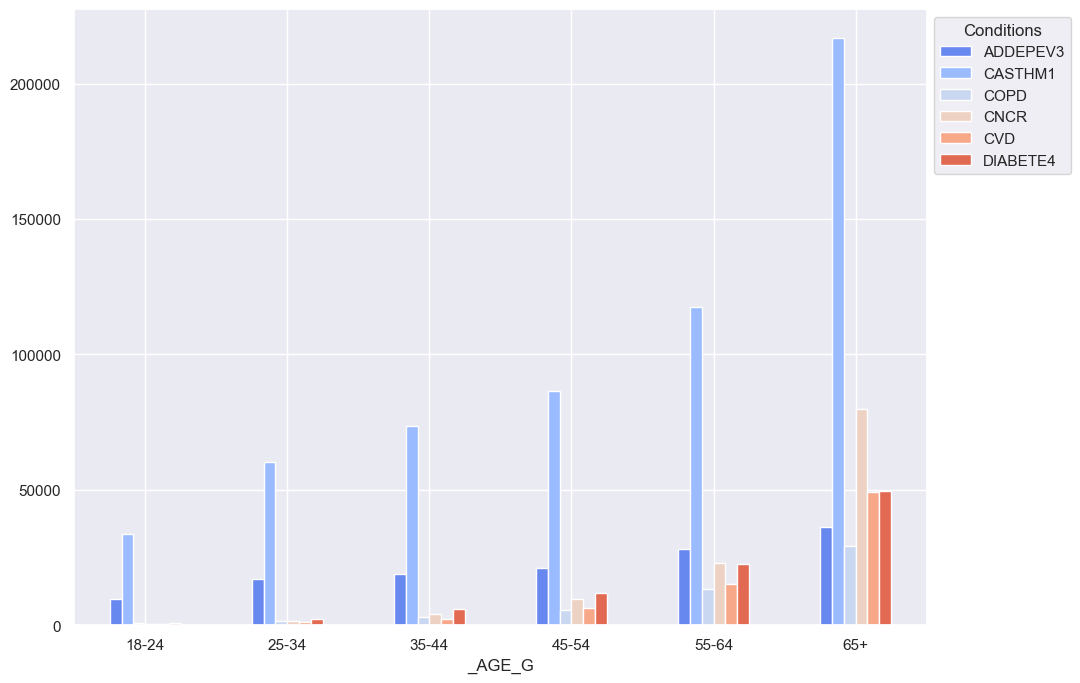

In [348]:
labels = ["18-24", "25-34", "35-44", "45-54", "55-64", "65+"]
plot_cond_demographic("_AGE_G", labels)

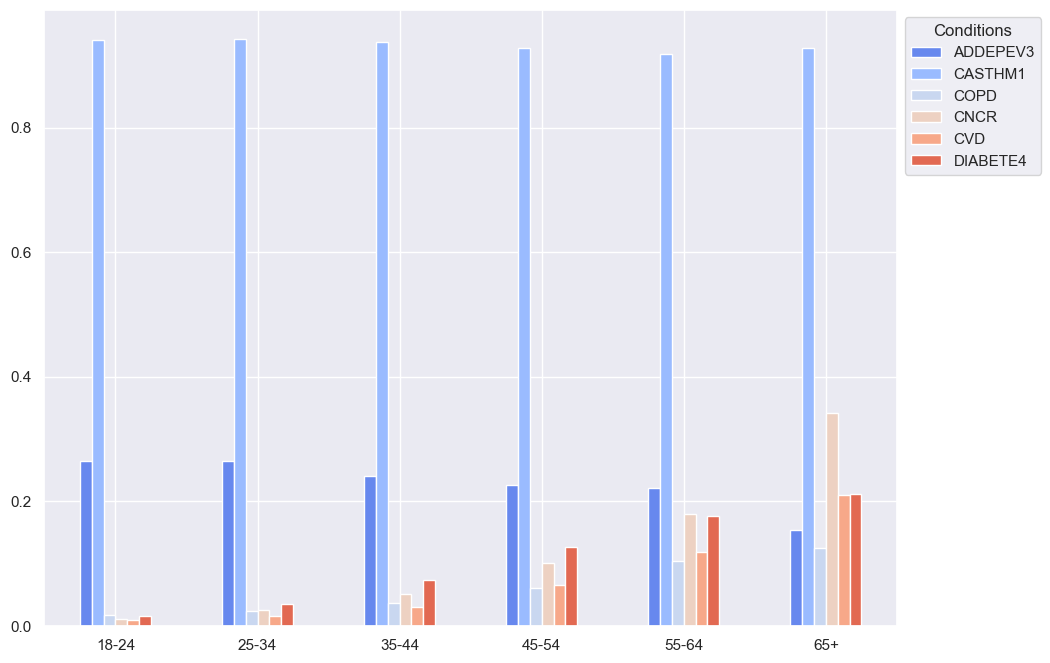

In [349]:
labels = ["18-24", "25-34", "35-44", "45-54", "55-64", "65+"]
plot_cond_demographic2("_AGE_G", labels)

Clearly as populations age they accumulate chronic conditions. The exceptions to this rule are depression, which exhibits a slightly downward trend and asthma, which remains somewhate constant. All the other chronic diseases appear to increase in frequency significantly as we move up the age groups.

##### (2) Chronic conditions VS Gender

In [350]:
crosstab_cond_demographic("_SEX")


 Crosstab of ADDEPEV3 vs _SEX
ADDEPEV3  _SEX       0      1
0         1.00  256740  44457
1         2.00  245117  86124

 Crosstab of _CASTHM1 vs _SEX
_CASTHM1  _SEX      0       1
0         1.00  13743  287454
1         2.00  30836  300405

 Crosstab of COPD vs _SEX
COPD  _SEX       0      1
0     1.00  278938  22259
1     2.00  300333  30908

 Crosstab of CNCR vs _SEX
CNCR  _SEX       0      1
0     1.00  248806  52391
1     2.00  265359  65882

 Crosstab of CVD vs _SEX
CVD  _SEX       0      1
0    1.00  260410  40787
1    2.00  297922  33319

 Crosstab of DIABETE4 vs _SEX
DIABETE4  _SEX       0      1
0         1.00  257672  43525
1         2.00  282352  48889


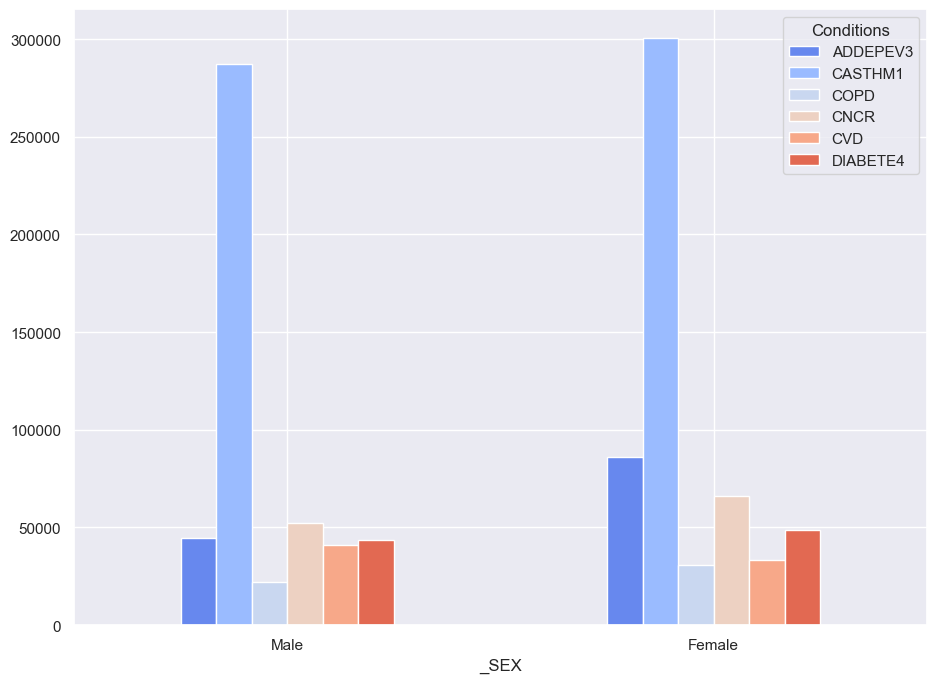

In [351]:
labels = ["Male", "Female"]
plot_cond_demographic("_SEX", labels)

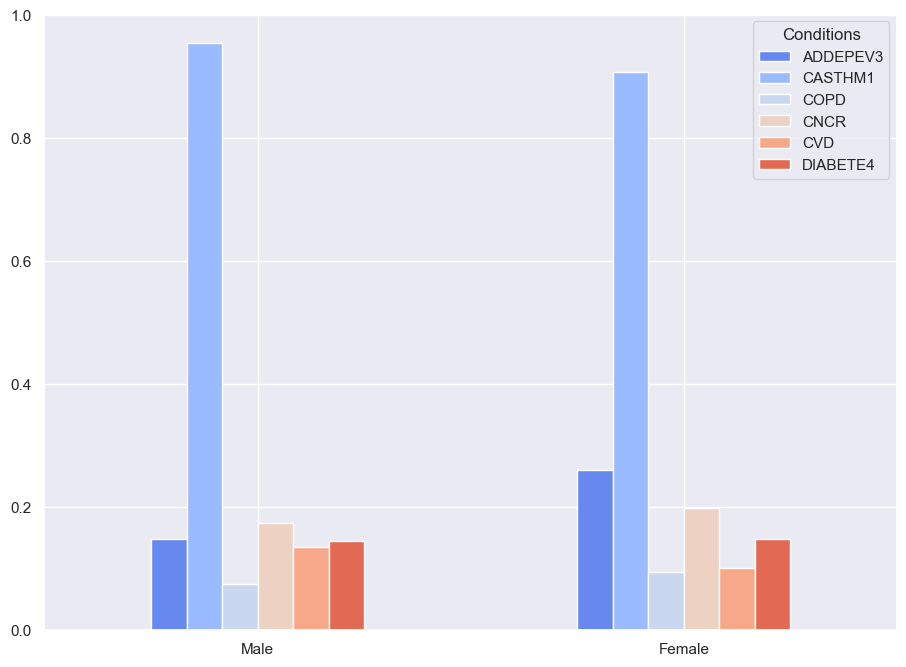

In [352]:
labels = ["Male", "Female"]
plot_cond_demographic2("_SEX", labels)

Relative to women, men appear to have a higher frequency of cardiovascular disease. And relative to men, women appear to have a higher frequency of depression.

##### (3) Distribution of chronic conditions VS Marital

In [353]:
crosstab_cond_demographic("MARITAL")


 Crosstab of ADDEPEV3 vs MARITAL
ADDEPEV3  MARITAL       0      1
0            1.00  279389  54216
1            2.00   60212  24466
2            3.00   58007  13304
3            4.00    7630   4075
4            5.00   77822  27232
5            6.00   16156   6707
6            9.00    2641    581

 Crosstab of _CASTHM1 vs MARITAL
_CASTHM1  MARITAL      0       1
0            1.00  18887  314718
1            2.00   8572   76106
2            3.00   6190   65121
3            4.00   1399   10306
4            5.00   7551   97503
5            6.00   1778   21085
6            9.00    202    3020

 Crosstab of COPD vs MARITAL
COPD  MARITAL       0      1
0        1.00  312420  21185
1        2.00   72782  11896
2        3.00   60270  11041
3        4.00   10093   1612
4        5.00   99311   5743
5        6.00   21407   1456
6        9.00    2988    234

 Crosstab of CNCR vs MARITAL
CNCR  MARITAL       0      1
0        1.00  267716  65889
1        2.00   67717  16961
2        3.00   48135  23

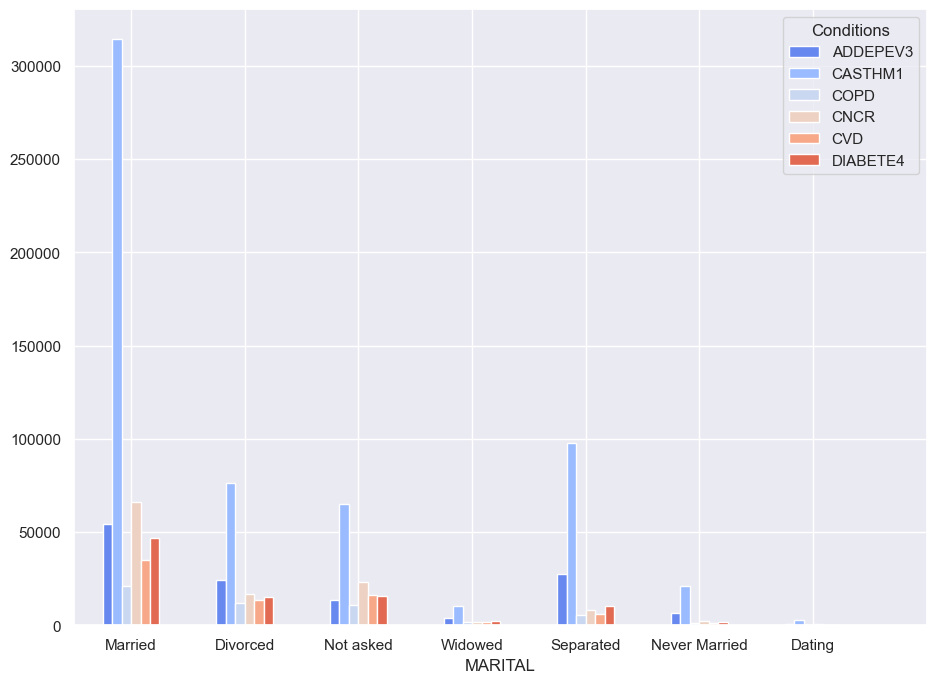

In [354]:
labels = ["Married", "Divorced", "Not asked","Widowed", "Separated", "Never Married", "Dating", ""]
plot_cond_demographic("MARITAL", labels)

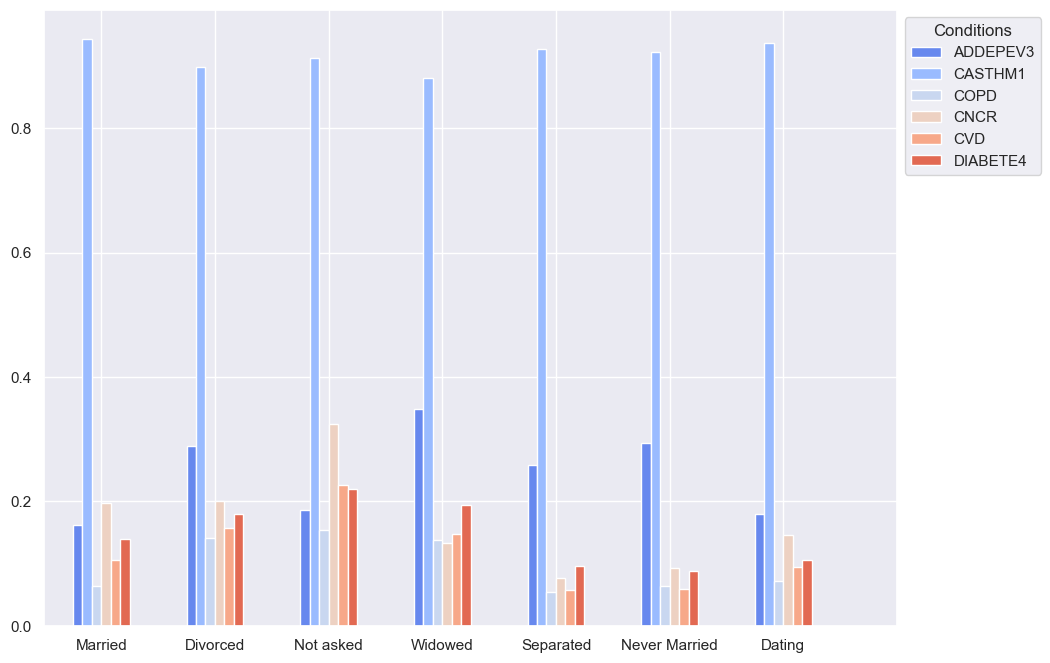

In [355]:
labels = ["Married", "Divorced", "Not asked","Widowed", "Separated", "Never Married", "Dating", ""]
plot_cond_demographic2("MARITAL", labels)

Widowed wome show the highest rate of depression, followed by peopel who are never married or divorced. Married people seem to be the least depressed, closely followed by people who are dating.<br>

Oddly, people who were not asked about their marital status have by far the highest rates of cancer. This is likely due to some idiosyncracy in the study design.<br>

People who are Separated, Never Married, and Dating have the lowest frequencies of cancer, cardiovascular disease, and diabetes. Likely this trend is caused by some external factors. For example, age may be a good predictor of having never been married and of being unlikely to have cancer.

##### (4) Distribution of chronic conditions VS Education

In [356]:
crosstab_cond_demographic("_EDUCAG")


 Crosstab of ADDEPEV3 vs _EDUCAG
ADDEPEV3  _EDUCAG       0      1
0            1.00   24970   8638
1            2.00  126121  32534
2            3.00  136530  41569
3            4.00  213197  47678
4            9.00    1039    162

 Crosstab of _CASTHM1 vs _EDUCAG
_CASTHM1  _EDUCAG      0       1
0            1.00   4028   29580
1            2.00  11761  146894
2            3.00  14285  163814
3            4.00  14440  246435
4            9.00     65    1136

 Crosstab of COPD vs _EDUCAG
COPD  _EDUCAG       0      1
0        1.00   27497   6111
1        2.00  140766  17889
2        3.00  160979  17120
3        4.00  248910  11965
4        9.00    1119     82

 Crosstab of CNCR vs _EDUCAG
CNCR  _EDUCAG       0      1
0        1.00   28411   5197
1        2.00  131478  27177
2        3.00  144994  33105
3        4.00  208265  52610
4        9.00    1017    184

 Crosstab of CVD vs _EDUCAG
CVD  _EDUCAG       0      1
0       1.00   26968   6640
1       2.00  136611  22044
2       3.00  1

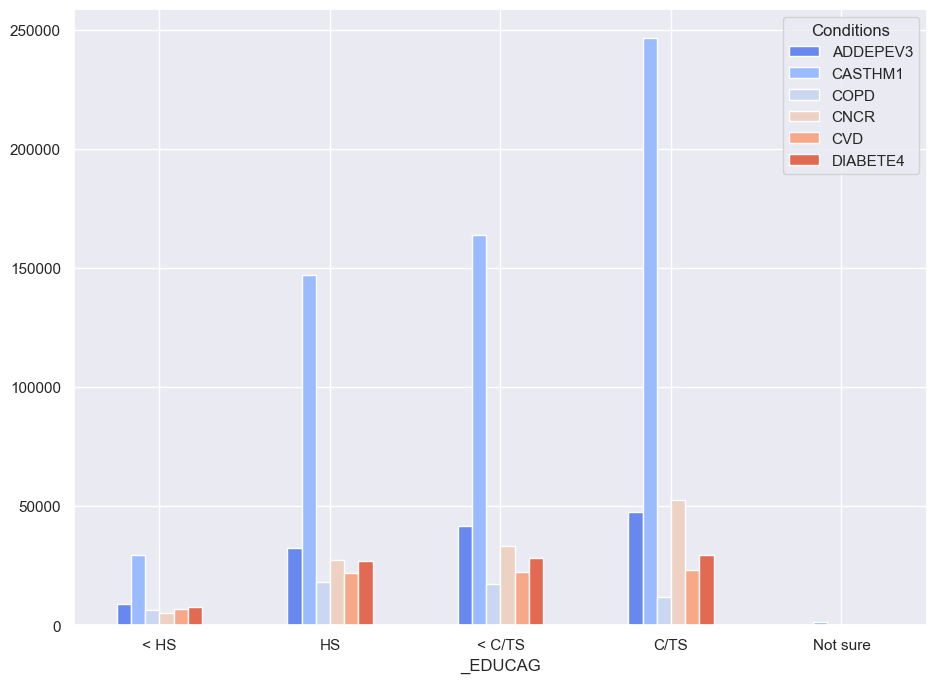

In [357]:
labels = ["< HS", "HS", "< C/TS", "C/TS", "Not sure"]
plot_cond_demographic("_EDUCAG", labels)

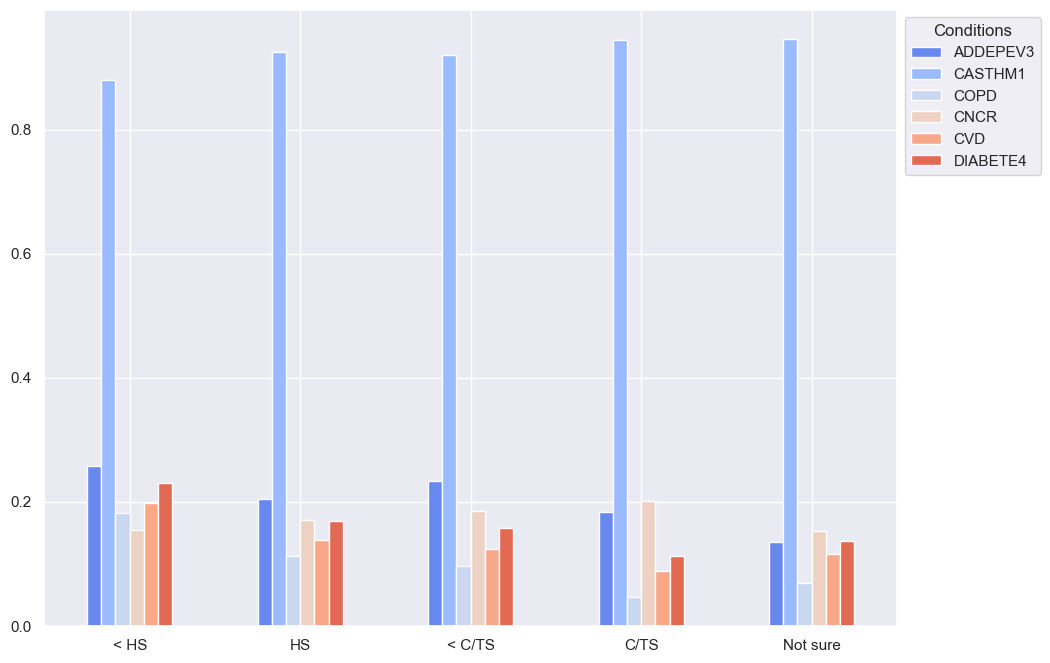

In [358]:
labels = ["< HS", "HS", "< C/TS", "C/TS", "Not sure"]
plot_cond_demographic2("_EDUCAG", labels)

Individuals with more education have lower rates of COPD, cardiovascular disease, depression, and diabetes. However, people with less education have slightly lower rates of asthma and notably lower rates of cancer.

##### (5) Distribution of chronic conditions VS Urban/Rural Status

In [359]:
crosstab_cond_demographic("_URBSTAT")


 Crosstab of ADDEPEV3 vs _URBSTAT
ADDEPEV3  _URBSTAT       0       1
0             1.00  424596  112109
1             2.00   77261   18472

 Crosstab of _CASTHM1 vs _URBSTAT
_CASTHM1  _URBSTAT      0       1
0             1.00  37664  499041
1             2.00   6915   88818

 Crosstab of COPD vs _URBSTAT
COPD  _URBSTAT       0      1
0         1.00  493400  43305
1         2.00   85871   9862

 Crosstab of CNCR vs _URBSTAT
CNCR  _URBSTAT       0      1
0         1.00  437813  98892
1         2.00   76352  19381

 Crosstab of CVD vs _URBSTAT
CVD  _URBSTAT       0      1
0        1.00  476135  60570
1        2.00   82197  13536

 Crosstab of DIABETE4 vs _URBSTAT
DIABETE4  _URBSTAT       0      1
0             1.00  459967  76738
1             2.00   80057  15676


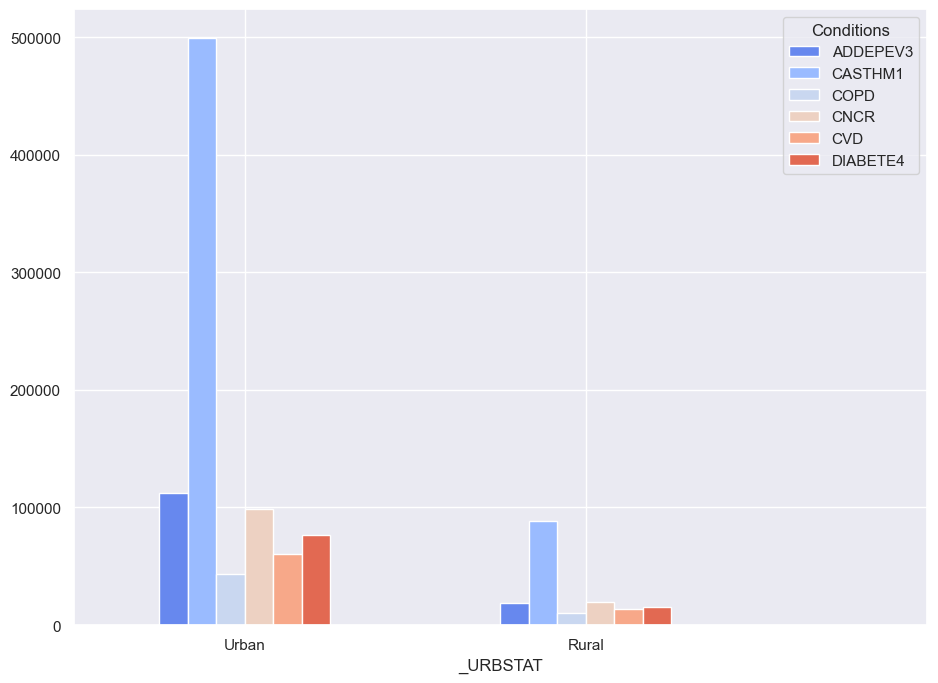

In [360]:
labels = ["Urban", "Rural" ," "]
plot_cond_demographic("_URBSTAT", labels)

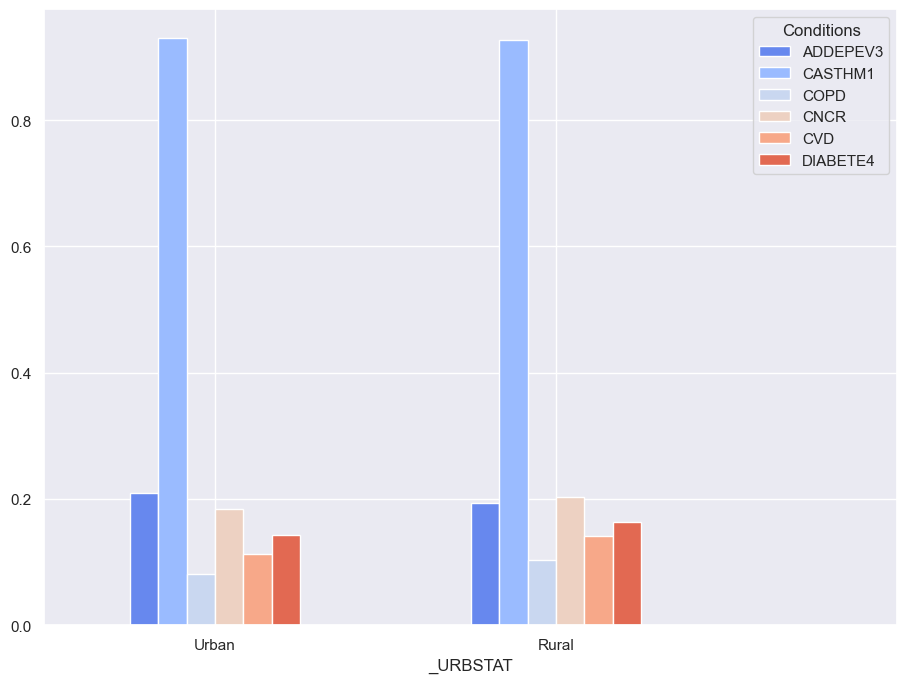

In [361]:
labels = ["Urban", "Rural" ," "]
plot_cond_demographic2("_URBSTAT", labels)

There are slightly higher rates of depression in urban areas. Not surprising.<br>

Meanwhile, there are higher rates of cancer - due to pesticides maybe? - as well as cardiovascular disease and diabetes - probably due to lifestyle factors - in rural areas.

##### (6) Distribution of chronic conditions VS Income

In [362]:
crosstab_cond_demographic("INCOME2")


 Crosstab of ADDEPEV3 vs INCOME2
ADDEPEV3  INCOME2       0      1
0            1.00   10595   6888
1            2.00   12379   7361
2            3.00   18824   8530
3            4.00   27351  10322
4            5.00   45323  14382
5            6.00   59534  15787
6            7.00   75187  17507
7            8.00  115624  21356
8            9.00   32785   6752
9           10.00   13810   2466
10          11.00   13798   2027
11          77.00   31552  10836
12          99.00   45095   6367

 Crosstab of _CASTHM1 vs INCOME2
_CASTHM1  INCOME2     0       1
0            1.00  3014   14469
1            2.00  3102   16638
2            3.00  3380   23974
3            4.00  3886   33787
4            5.00  5010   54695
5            6.00  5072   70249
6            7.00  5340   87354
7            8.00  6092  130888
8            9.00  1876   37661
9           10.00   644   15632
10          11.00   532   15293
11          77.00  3936   38452
12          99.00  2695   48767

 Crosstab of COPD vs 

In [363]:
# Taking 2021 values and matching with the associated 2019 codes
cf["INCOME2"] = cf["INCOME2"].replace({99:77, 9:8, 10:8, 11:8})
cf["INCOME2"].unique()

array([ 3.,  5.,  7., 77.,  8.,  6.,  4.,  2., nan,  1.])

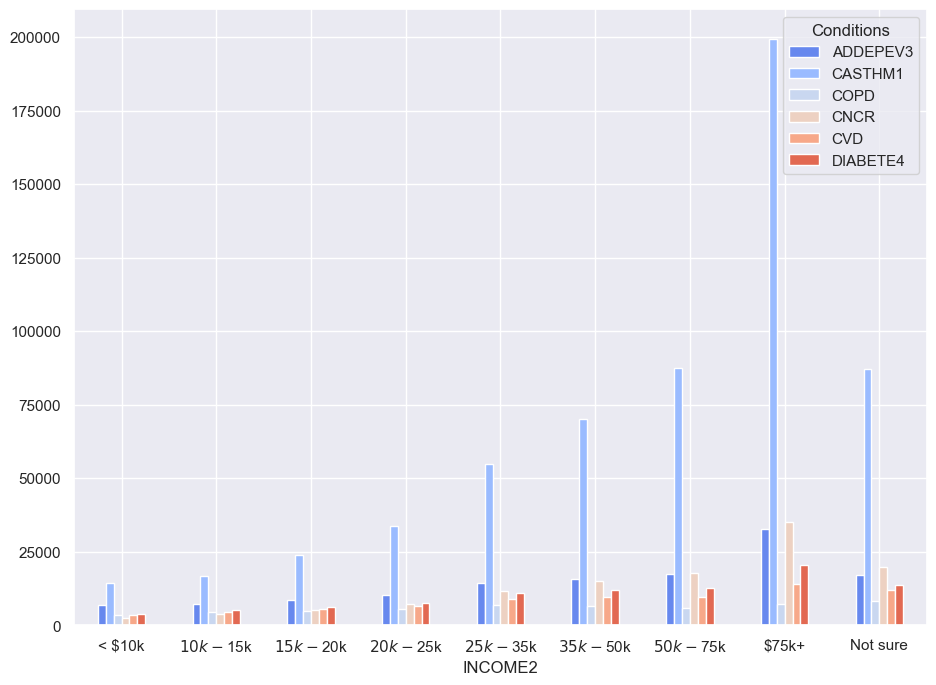

In [364]:
labels = ["< $10k", "$10k - $15k", "$15k - $20k", "$20k - $25k", "$25k - $35k", "$35k - $50k", "$50k - $75k", "$75k+", "Not sure"]
plot_cond_demographic("INCOME2", labels)

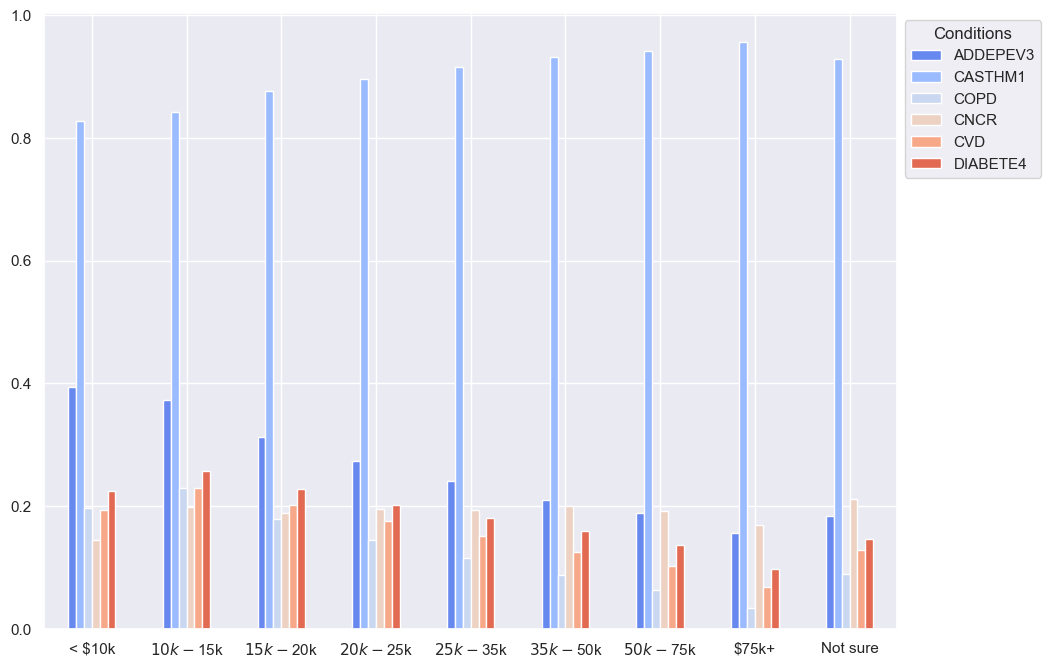

In [365]:
labels = ["< $10k", "$10k - $15k", "$15k - $20k", "$20k - $25k", "$25k - $35k", "$35k - $50k", "$50k - $75k", "$75k+", "Not sure"]
plot_cond_demographic2("INCOME2", labels)

As with education, it's notable that populations with larger incomes have from a lower frequency of COPD, diabetes, cardiovascular disease, and depression. And, again they have higher rates of asthma.<br>

It's also interesting that the survey clearly more people in the higher income categories, which may also reflect the population's distribution by income.

##### 6) Distribution of Chronic conditions vs  BMI

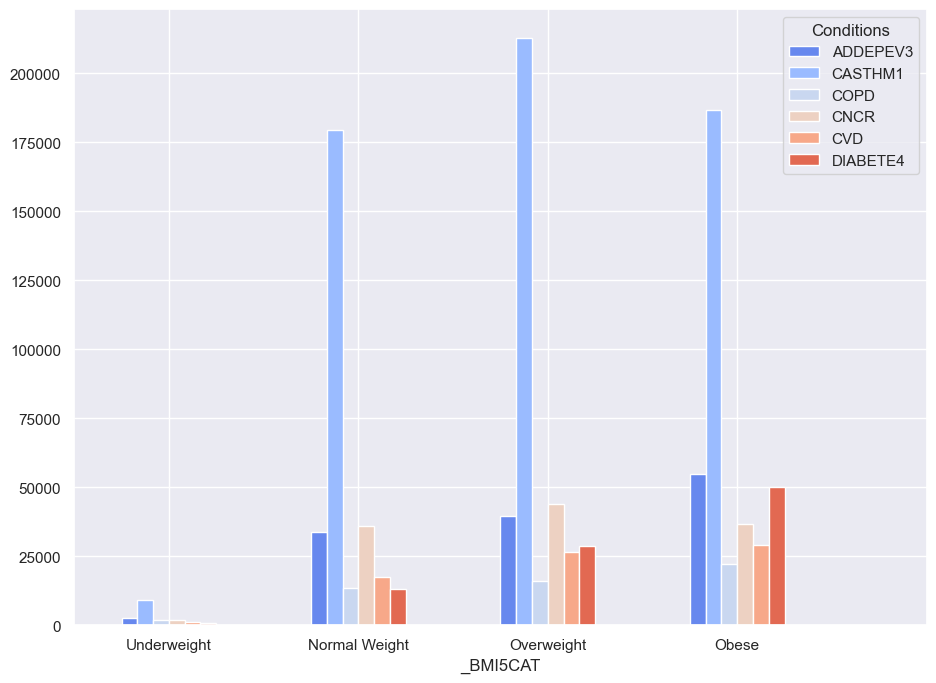

In [366]:
labels = ["Underweight", "Normal Weight", "Overweight", "Obese", ""] # Not sure didn't even show up
plot_cond_demographic("_BMI5CAT", labels)

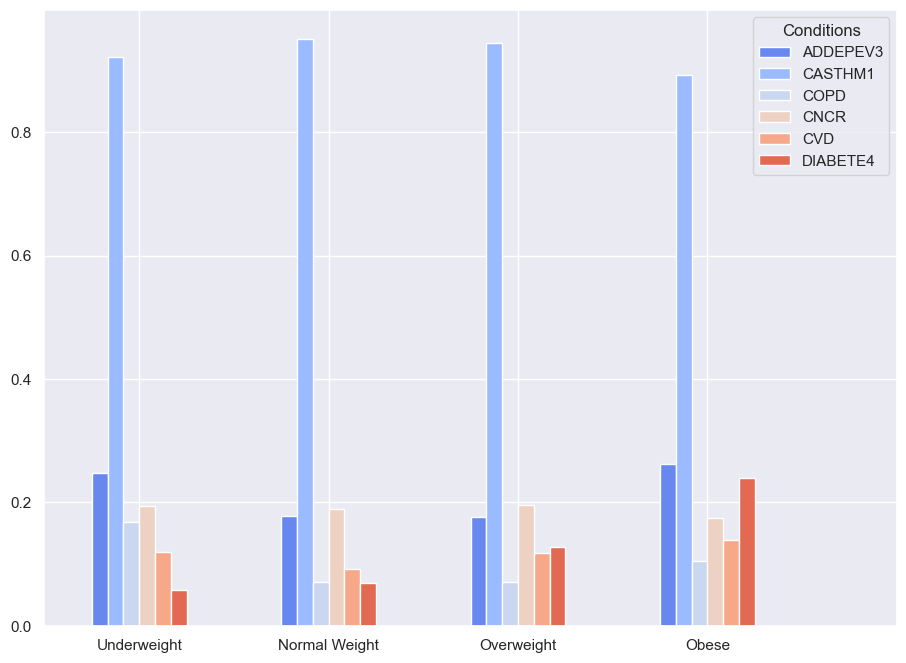

In [367]:
labels = ["Underweight", "Normal Weight", "Overweight", "Obese", ""] # Not sure didn't even show up
plot_cond_demographic2("_BMI5CAT", labels)

There don't seem to be many underweight people in the population. That on its own is interesting. They also have the highest rate of COPD, which may have to do with the appetite reducing affect of nicotine.

Also, diabetes and cardiovascular disease both clearly occur with greater frequency in more overweight populations.

And depression occurs the most in people at the extremes.

Cancer appears relatively consistently across weight classes.

##### 7) Distribution of Chronic conditions vs Consumption of fruit per day

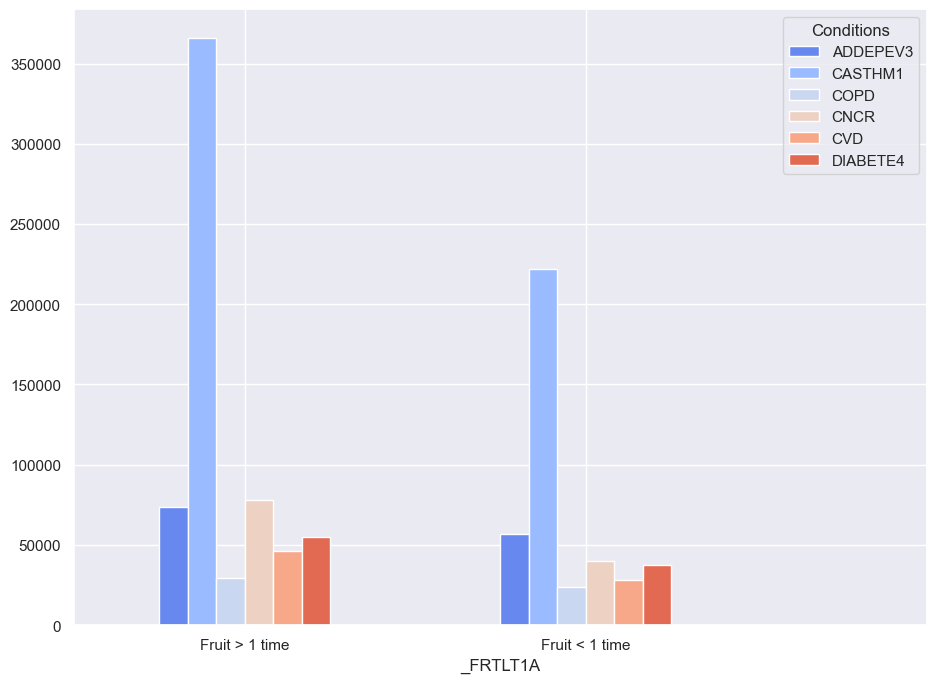

In [368]:
labels = ["Fruit > 1 time", "Fruit < 1 time", ""] # Refused didn't even show up
plot_cond_demographic("_FRTLT1A", labels)

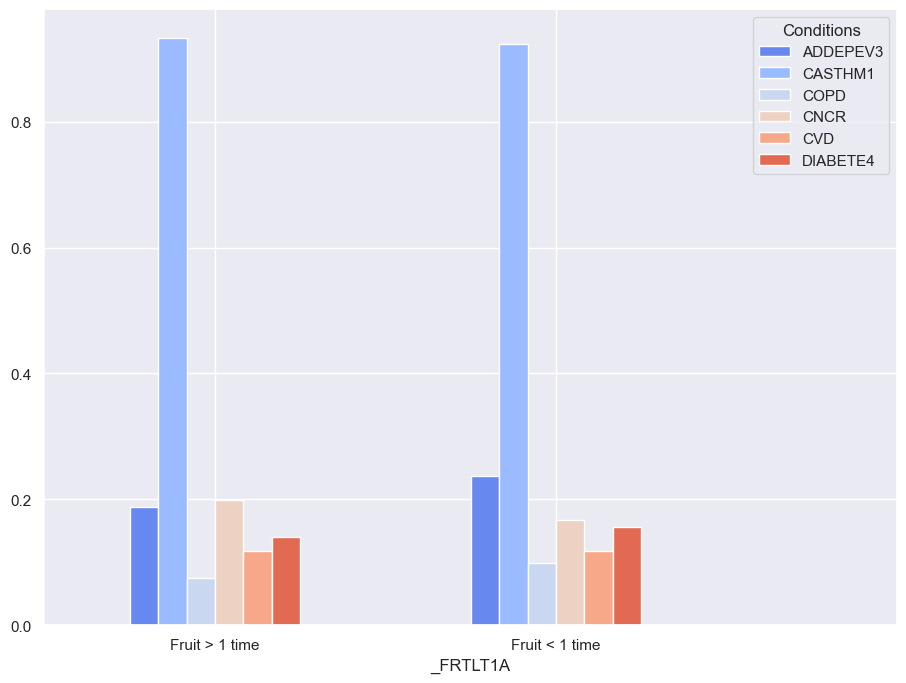

In [369]:
labels = ["Fruit > 1 time", "Fruit < 1 time", ""] # Refused didn't even show up
plot_cond_demographic2("_FRTLT1A", labels)

People who eat fruit >1 time per day have less depression, COPD, and diabetes. However, they appear to have more cancer, perhaps related to fructose, which like other simple sugars may provide fuel for tumors to grow.

##### 8) Distribution of Chronic conditions vs Participate in any physical activity other than regular job

In [370]:
cf["EXERANY2"].value_counts()

1.00    479021
2.00    152548
7.00       632
9.00       237
Name: EXERANY2, dtype: int64

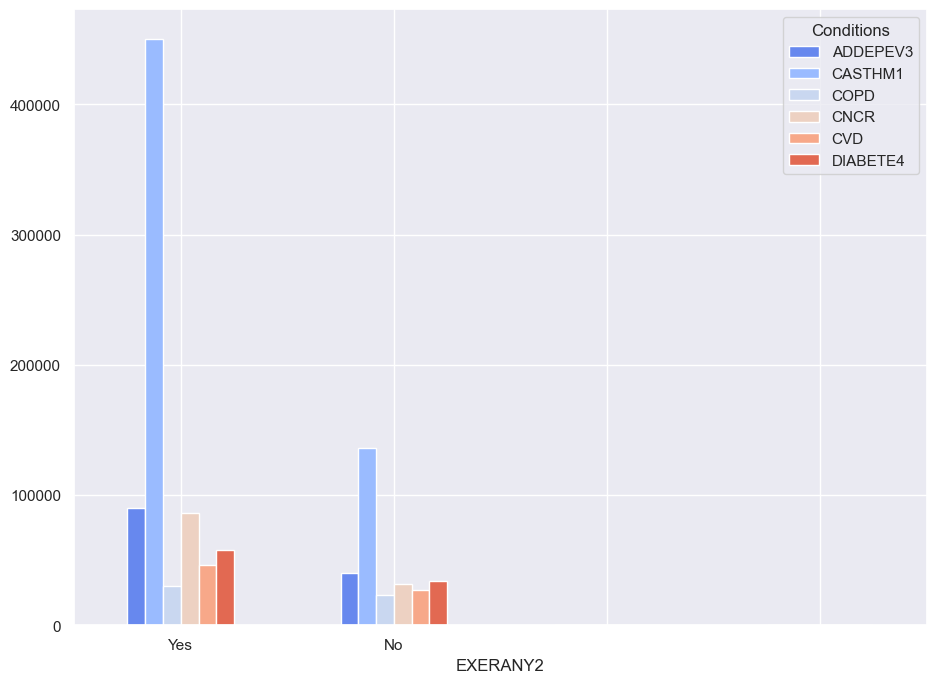

In [371]:
labels = ["Yes", "No", "", ""] # Not sure & refused didn't even show up
plot_cond_demographic("EXERANY2", labels)

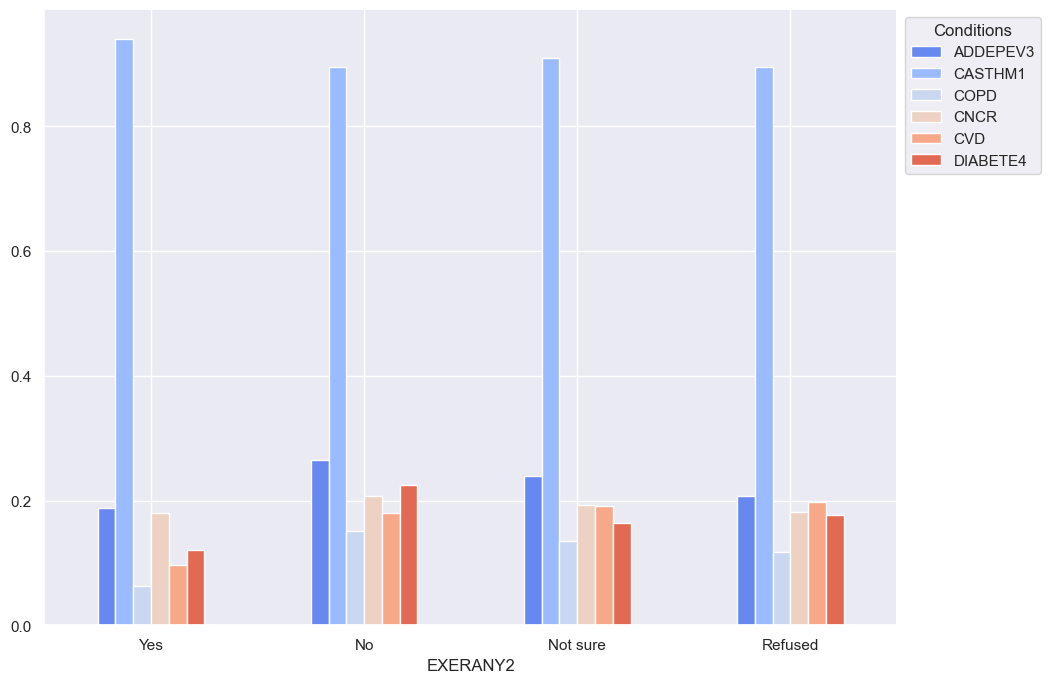

In [372]:
labels = ["Yes", "No", "Not sure", "Refused"] 
plot_cond_demographic2("EXERANY2", labels)

People who aren't exercising clearly have higher rates of depression, COPD, cancer, cardiovascular disease, and diabetes. Although exercisers appear to experience more asthma. Or maybe they are just diagnosed more often and they are able to exercise thanks to their inhalers!

#### 2.2 Distribution of chronic conditions vs geography
##### Merging data from Region_Division_State with dataframe

In [373]:
regionCode = pd.read_excel('data/Region_Division_State.xlsx')
df = df.merge(regionCode, how='left', left_on='STATE_CODE', right_on='StateFips')

##### Analyze 'CMB_binary' value distribution by state

In [374]:
df["CMB_binary"] = df["CMB_binary"].astype(int)
cmb_binary_freq = df.groupby('Name')['CMB_binary'].mean().sort_values()
cmb_binary_freq.head(10)

Name
Hawaii          0.38
California      0.39
Alaska          0.40
New Jersey      0.40
Colorado        0.41
Illinois        0.41
Massachusetts   0.42
Iowa            0.42
Minnesota       0.43
Connecticut     0.43
Name: CMB_binary, dtype: float64

<AxesSubplot: xlabel='Name'>

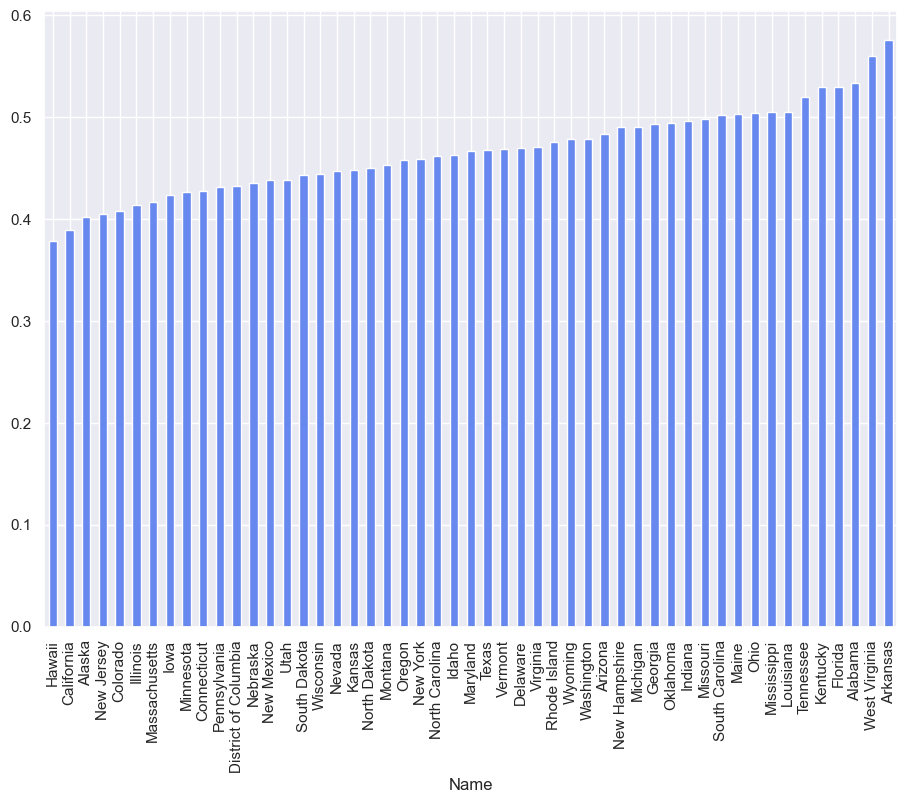

In [375]:
# plot a histogram of the data
cmb_binary_freq.plot(kind='bar')

The top 6 most unhealthy states step up from the steady incline with two particularly steep steps for the last two. In order from least healthy, these are:
1. Arkansas
2. West Virginia
3. Alabama
4. Florida
5. Kentucky
6. Tennessee

In [376]:
cmb_binary_freq.tail(10)

Name
Maine           0.50
Ohio            0.50
Mississippi     0.50
Louisiana       0.50
Tennessee       0.52
Kentucky        0.53
Florida         0.53
Alabama         0.53
West Virginia   0.56
Arkansas        0.58
Name: CMB_binary, dtype: float64

* From 'CMB_binary' column, we know the 10 most healthy states are: Hawaii, California, Alaska, New Jersey, Colorado, Illinois, Massachusetts, Iowa, Minnesota, Connecticut;<br>

* From 'CMB_binary' column, we know the 10 least healthy states are: Arkansas, West Virginia, Alabama, Florida, Kentucky, Tennessee, Louisiana, Mississippi, Ohio, (and sadly) Maine 

In [377]:
# cmb_multiclass_freq = df.groupby('Name')['CMB_multiclass'].value_counts(normalize=True).reset_index()
cmb_multiclass_freq = df.groupby('Name')['CMB_multiclass'].value_counts(normalize=True).rename('CMB_multiclass_freq').reset_index()
#cmb_multiclass_freq = cmb_multiclass_freq.reset_index()
cmb_multiclass_freq

,Name,CMB_multiclass,CMB_multiclass_freq
0,Alabama,0,0.47
1,Alabama,1,0.32
2,Alabama,2,0.15
3,Alabama,3+,0.06
4,Alaska,0,0.60
...,...,...,...
199,Wisconsin,3+,0.03
200,Wyoming,0,0.52
201,Wyoming,1,0.32
202,Wyoming,2,0.12


In [378]:
# Group the DataFrame by the 'b' column
groups = cmb_multiclass_freq.groupby('CMB_multiclass')

# Create a dictionary of DataFrames, with one DataFrame for each group
dict_of_dfs = {group_name: group_df for group_name, group_df in groups}

# Print each DataFrame in the dictionary
for group_name, group_df in dict_of_dfs.items():
    dict_of_dfs[group_name] = group_df.sort_values(by='CMB_multiclass_freq')
    print(f"Group {group_name}:")
    print(group_df.head())


Group 0:
          Name CMB_multiclass  CMB_multiclass_freq
0      Alabama              0                 0.47
4       Alaska              0                 0.60
8      Arizona              0                 0.52
12    Arkansas              0                 0.42
16  California              0                 0.61
Group 1:
          Name CMB_multiclass  CMB_multiclass_freq
1      Alabama              1                 0.32
5       Alaska              1                 0.28
9      Arizona              1                 0.32
13    Arkansas              1                 0.34
17  California              1                 0.28
Group 2:
          Name CMB_multiclass  CMB_multiclass_freq
2      Alabama              2                 0.15
6       Alaska              2                 0.09
10     Arizona              2                 0.12
14    Arkansas              2                 0.16
18  California              2                 0.08
Group 3+:
          Name CMB_multiclass  CMB_multiclass

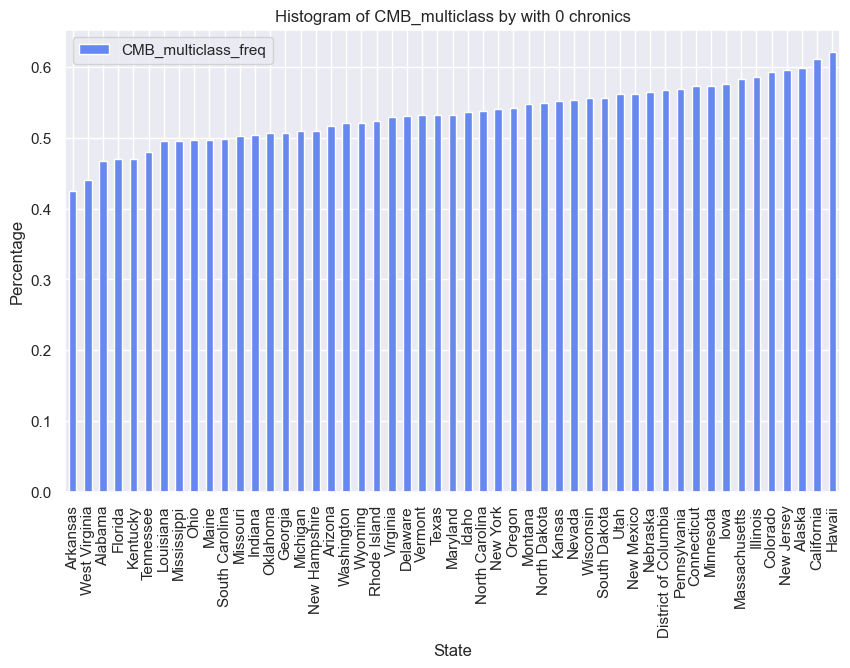

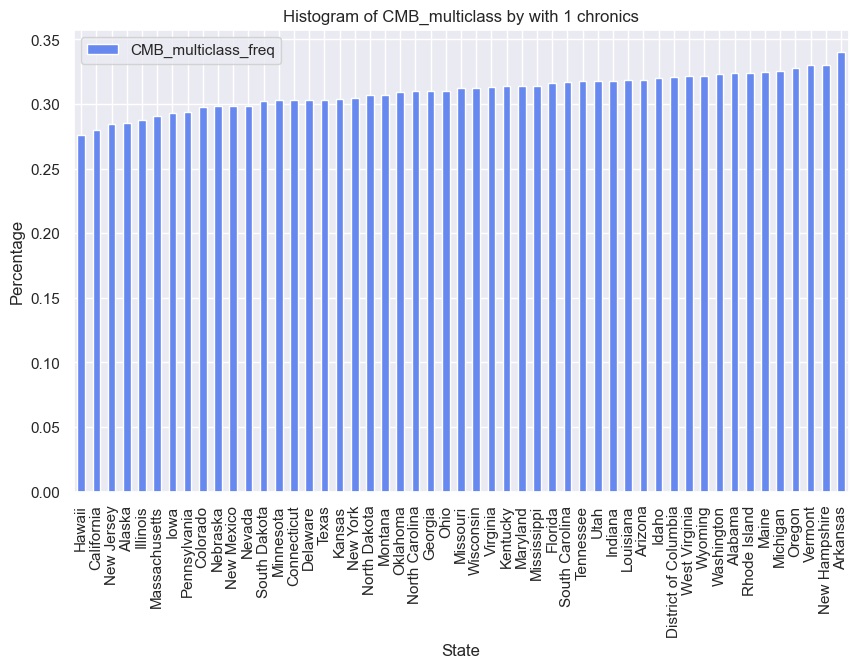

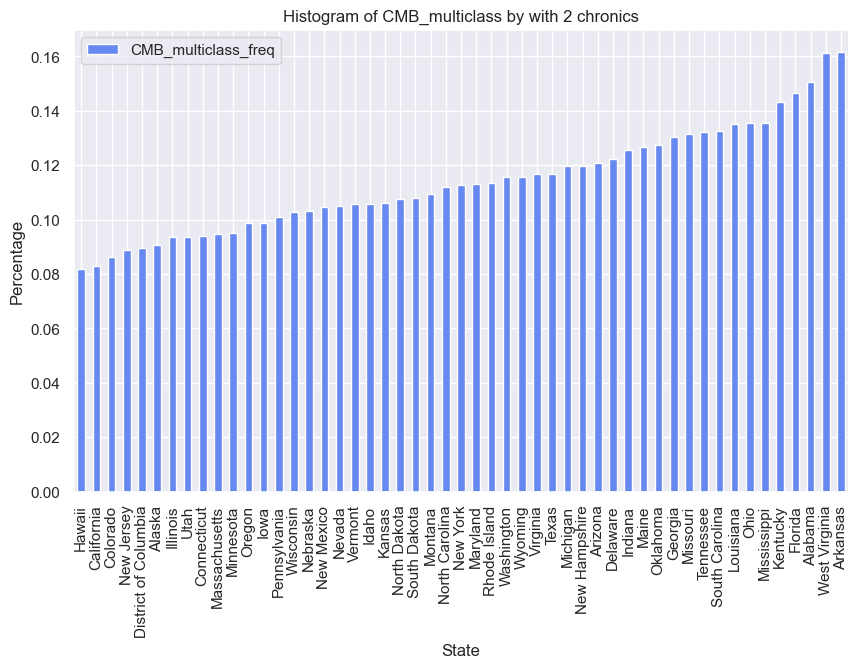

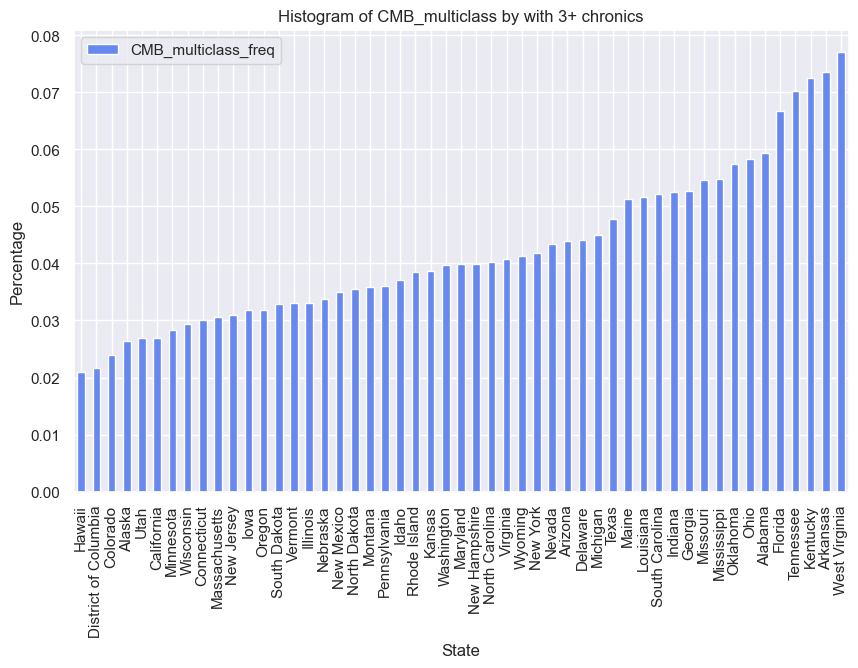

In [379]:
def plot_cmb_multi(df_name, df):
    # Assuming your dataframe is called cmb_multiclass_freq
    fig, ax = plt.subplots(figsize=(10, 6))
    df.plot(kind='bar', x='Name', y='CMB_multiclass_freq',ax=ax)

    # Set the labels for x-axis and y-axis
    ax.set_xlabel('State')
    ax.set_ylabel('Percentage')

    # Set the title for the plot
    ax.set_title(f'Histogram of CMB_multiclass by with {df_name} chronics')

    # Show the plot
    plt.show()

    
for group_name, group_df in dict_of_dfs.items():
    plot_cmb_multi(group_name, group_df)

In [380]:
group_df = dict_of_dfs[0]
print(f"Group 0")
print(group_df.head(10))
print(group_df.tail(10))

Group 0
              Name CMB_multiclass  CMB_multiclass_freq
12        Arkansas              0                 0.42
192  West Virginia              0                 0.44
0          Alabama              0                 0.47
36         Florida              0                 0.47
68        Kentucky              0                 0.47
168      Tennessee              0                 0.48
72       Louisiana              0                 0.50
96     Mississippi              0                 0.50
140           Ohio              0                 0.50
76           Maine              0                 0.50
              Name CMB_multiclass  CMB_multiclass_freq
24     Connecticut              0                 0.57
92       Minnesota              0                 0.57
60            Iowa              0                 0.58
84   Massachusetts              0                 0.58
52        Illinois              0                 0.59
20        Colorado              0                 0.59
12

In [381]:
group_df = dict_of_dfs[1]
print(f"Group 1")
print(group_df.head(10))
print(group_df.tail(10))

Group 1
              Name CMB_multiclass  CMB_multiclass_freq
45          Hawaii              1                 0.28
17      California              1                 0.28
121     New Jersey              1                 0.28
5           Alaska              1                 0.28
53        Illinois              1                 0.29
85   Massachusetts              1                 0.29
61            Iowa              1                 0.29
153   Pennsylvania              1                 0.29
21        Colorado              1                 0.30
109       Nebraska              1                 0.30
              Name CMB_multiclass  CMB_multiclass_freq
201        Wyoming              1                 0.32
189     Washington              1                 0.32
1          Alabama              1                 0.32
157   Rhode Island              1                 0.32
77           Maine              1                 0.33
89        Michigan              1                 0.33
14

In [382]:
group_df = dict_of_dfs[2]
print(f"Group 2")
print(group_df.head(10))
print(group_df.tail(10))

Group 2
                     Name CMB_multiclass  CMB_multiclass_freq
46                 Hawaii              2                 0.08
18             California              2                 0.08
22               Colorado              2                 0.09
122            New Jersey              2                 0.09
34   District of Columbia              2                 0.09
6                  Alaska              2                 0.09
54               Illinois              2                 0.09
178                  Utah              2                 0.09
26            Connecticut              2                 0.09
86          Massachusetts              2                 0.09
               Name CMB_multiclass  CMB_multiclass_freq
170       Tennessee              2                 0.13
162  South Carolina              2                 0.13
74        Louisiana              2                 0.14
142            Ohio              2                 0.14
98      Mississippi           

In [383]:
group_df = dict_of_dfs['3+']
print(f"Group 3+")
print(group_df.head(10))
print(group_df.tail(10))

Group 3+
                     Name CMB_multiclass  CMB_multiclass_freq
47                 Hawaii             3+                 0.02
35   District of Columbia             3+                 0.02
23               Colorado             3+                 0.02
7                  Alaska             3+                 0.03
179                  Utah             3+                 0.03
19             California             3+                 0.03
95              Minnesota             3+                 0.03
199             Wisconsin             3+                 0.03
27            Connecticut             3+                 0.03
87          Massachusetts             3+                 0.03
              Name CMB_multiclass  CMB_multiclass_freq
103       Missouri             3+                 0.05
99     Mississippi             3+                 0.05
147       Oklahoma             3+                 0.06
143           Ohio             3+                 0.06
3          Alabama             3+ 

* From 'CMB_Multiclass' column, we again see the 5 most healthy states are: Hawaii, California, Alaska, New Jersey, Colorado;<br>

* From 'CMB_Multiclass' column, we again see the 5 least healthy states are: Arkansas, West Virginia, Alabama, Florida, Kentucky 

#### 2.4 Demographics per Region

##### 2.4.1 Adding region and state to our dataframe

In [384]:
state_region = ['Region', 'Name'] 
cf[state_region] = df[state_region]
cf.head()

,ADDEPEV3,_CASTHM1,COPD,CNCR,CVD,DIABETE4,_AGE_G,MARITAL,_SEX,_EDUCAG,_BMI5CAT,_URBSTAT,INCOME2,RENTHOM1,EXERANY2,_FRTLT1A,Region,Name
0,0,1,0,0,0,0,6.00,2.00,2.00,1.00,3.00,1.00,3.00,2.00,2.00,1.00,South Region,Alabama
1,0,1,0,0,0,0,6.00,1.00,2.00,3.00,2.00,1.00,5.00,1.00,1.00,1.00,South Region,Alabama
2,0,1,0,0,0,1,6.00,3.00,2.00,4.00,4.00,1.00,7.00,1.00,1.00,1.00,South Region,Alabama
4,0,1,0,0,0,0,6.00,1.00,2.00,3.00,2.00,2.00,77.00,1.00,2.00,1.00,South Region,Alabama
6,0,0,1,0,0,1,6.00,2.00,1.00,4.00,4.00,2.00,7.00,1.00,1.00,1.00,South Region,Alabama


##### 2.4.2 Grouping demographics by geographic region

In [385]:
def plot_dem_by_region(demographic_cols):
    dem_by_region = cf.groupby("Region")[demographic_cols].sum()

    # Replace '_' character with space character in demographic columns
    dem_by_region.columns = [dem.replace('_', '') for dem in dem_by_region.columns]

    # Set the color palette for the plot
    colors = sns.color_palette('coolwarm', n_colors=len(demographic_cols))
    sns.set_palette(colors)

    dem_by_region.plot(kind='bar', rot=0)

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, title='Demographics', bbox_to_anchor=(1,1))
    
    plt.show()

We plotted and looked at these data both in their original form and normalized, but couldn't make sense of our y-axis, so removed.

#### 2.5 Chronic conditions by Region

In [386]:
def plot_cond_by_region(chronic_conditions):
    cond_by_region = cf.groupby("Region")[chronic_conditions].sum()

    # Replace '_' character with space character in demographic columns
    cond_by_region.columns = [cond.replace('_', '') for cond in cond_by_region.columns]

    # Set the color palette for the plot
    colors = sns.color_palette('coolwarm', n_colors=len(chronic_conditions))
    sns.set_palette(colors)

    cond_by_region.plot(kind='bar', rot=0)

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, title='Conditions', bbox_to_anchor=(1,1))
    
    plt.show()

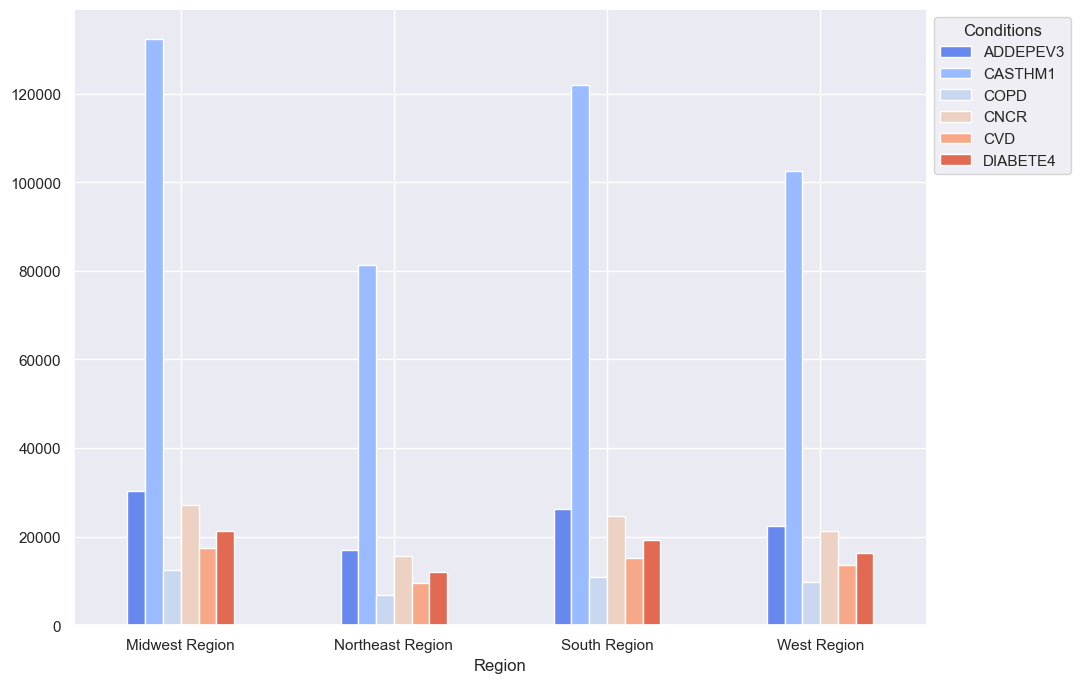

In [387]:
plot_cond_by_region(chronic_conditions)

Midwest Region      147734
South Region        135577
West Region         114280
Northeast Region     89989
Name: Region, dtype: int64
                  ADDEPEV3  _CASTHM1  COPD  CNCR  CVD  DIABETE4
Midwest Region        0.21      0.90  0.08  0.18 0.12      0.14
Northeast Region      0.19      0.90  0.08  0.17 0.11      0.13
South Region          0.19      0.90  0.08  0.18 0.11      0.14
West Region           0.20      0.90  0.09  0.19 0.12      0.14


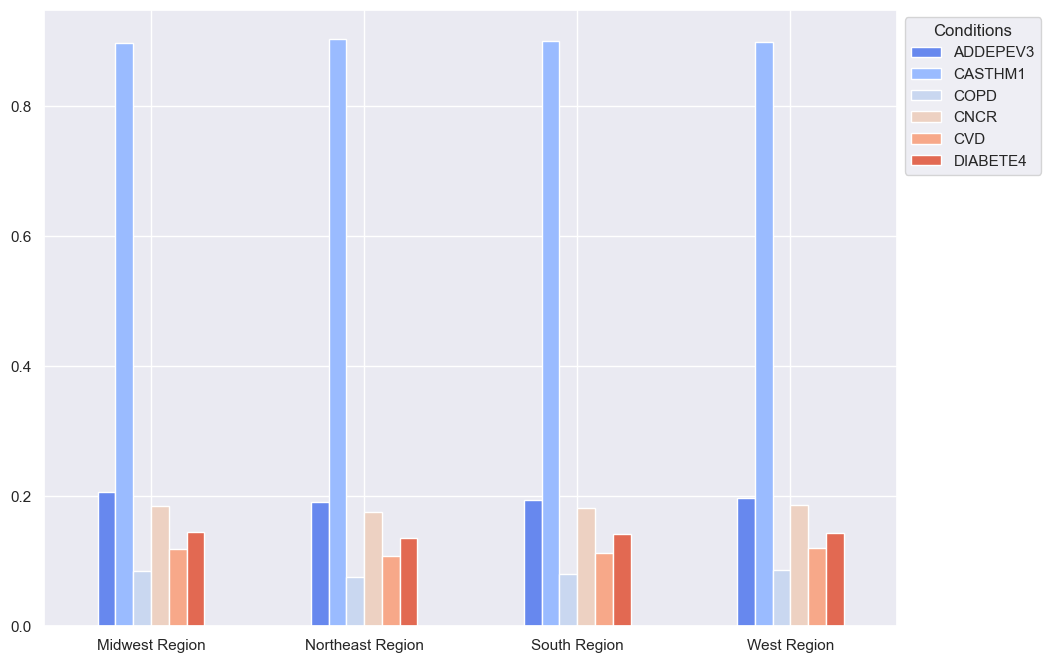

In [388]:
def plot_cond_by_region2(chronic_conditions):
    cond_by_region = cf.groupby("Region")[chronic_conditions].sum()
    count = cf['Region'].value_counts()
    print(count)
    cond_by_region = cond_by_region.div(count, axis = 0)
    print(cond_by_region)
    # Replace '_' character with space character in demographic columns
    cond_by_region.columns = [cond.replace('_', '') for cond in cond_by_region.columns]

    # Set the color palette for the plot
    colors = sns.color_palette('coolwarm', n_colors=len(chronic_conditions))
    sns.set_palette(colors)

    cond_by_region.plot(kind='bar', rot=0)

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, title='Conditions', bbox_to_anchor=(1,1))
    
    plt.show()
plot_cond_by_region2(chronic_conditions)

This lack of difference by region is hard to explain. Did we make a mistake?

#### 2.6 Comparing trend of chronic conditions for two years

In [389]:
cf["Year"] = df["IYEAR"]
cf["Year"] = cf["Year"].replace("b'2021'", "2021")
cf["Year"].value_counts()

2019       234233
2021       231522
b'2022'     12177
2020         9648
Name: Year, dtype: int64

In [390]:
cond_by_year = cf.groupby('Year')[chronic_conditions].sum()
cond_by_year

,ADDEPEV3,_CASTHM1,COPD,CNCR,CVD,DIABETE4
Year,,,,,,
2019,44913,211123,19966,43770,27781,33799
2020,1909,8658,828,1666,1112,1346
2021,46798,207524,18154,41440,25556,32086
b'2022',2438,10963,892,2025,1279,1596


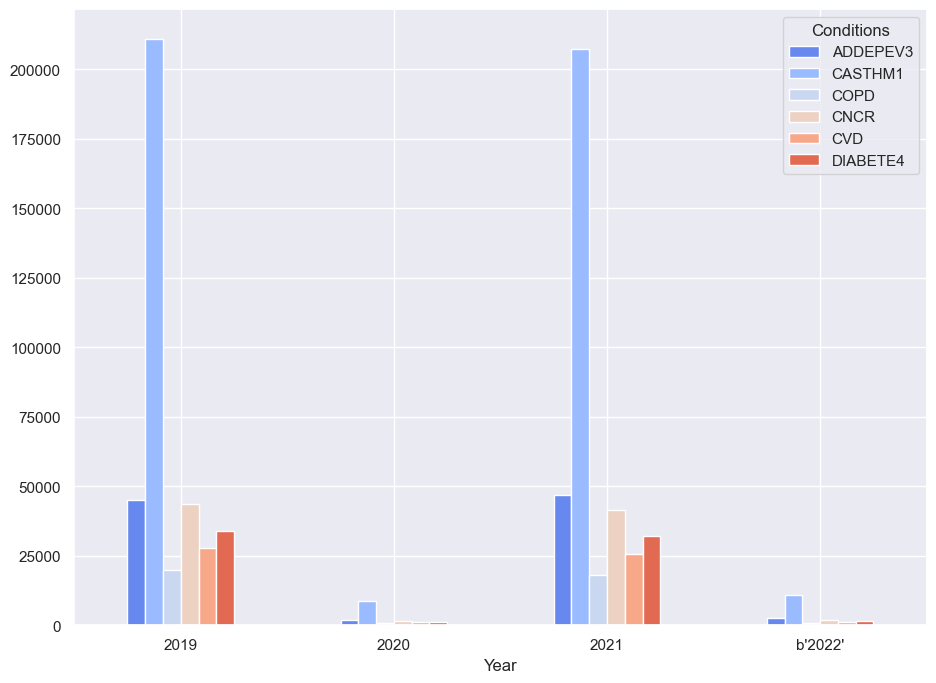

In [391]:
# Replace '_' character with space character in demographic columns
cond_by_year.columns = [cond.replace('_', '') for cond in cond_by_year.columns]

# Set the color palette for the plot
colors = sns.color_palette('coolwarm', n_colors=len(chronic_conditions))
sns.set_palette(colors)

cond_by_year.plot(kind='bar', rot=0)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, title='Conditions', bbox_to_anchor=(1,1))

plt.show()

Over the two years, the frequencies of the disease seem stable, which is what we would expect.

### 3. Analysis Part 2:

#### 3.1 Feature and response space

In [392]:
feature_cols.remove('_STATE')

In [393]:
X = df[df["IYEAR"] == "b'2021'"][feature_cols]
X.head()

,INCOME2,_AGE_G,MARITAL,_SEX,_EDUCAG,_RACE,SMOKE100,_BMI5CAT,_MENT14D,_PHYS14D,_URBSTAT,VETERAN3,RENTHOM1,CHECKUP1,CHCKDNY2,EXERANY2,_FRTLT1A,_VEGLT1A,FLUSHOT7
309894,5.00,6.00,1.00,2.00,2.00,1.00,1.00,1.00,2.00,3.00,1.00,2.00,1.00,2.00,2.00,2.00,1.00,1.00,1.00
309895,3.00,6.00,3.00,2.00,2.00,2.00,2.00,3.00,1.00,1.00,1.00,2.00,1.00,1.00,2.00,2.00,1.00,2.00,2.00
309896,7.00,5.00,1.00,2.00,2.00,1.00,2.00,4.00,2.00,1.00,1.00,2.00,1.00,1.00,2.00,1.00,1.00,1.00,1.00
309897,4.00,6.00,1.00,1.00,1.00,7.00,2.00,3.00,1.00,3.00,1.00,2.00,1.00,1.00,2.00,1.00,1.00,1.00,1.00
309898,6.00,6.00,1.00,1.00,3.00,1.00,1.00,2.00,1.00,1.00,2.00,2.00,1.00,1.00,2.00,2.00,2.00,2.00,1.00


In [394]:
y = df[df["IYEAR"] == "b'2021'"][response_cols]
y.head()

,CMB_binary,CMB_multiclass
309894,0,0
309895,1,2
309896,1,1
309897,1,2
309898,1,1


#### 3.2 Standardizing data

In [395]:
scaler = StandardScaler()

scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns = feature_cols)

X.head()

,INCOME2,_AGE_G,MARITAL,_SEX,_EDUCAG,_RACE,SMOKE100,_BMI5CAT,_MENT14D,_PHYS14D,_URBSTAT,VETERAN3,RENTHOM1,CHECKUP1,CHCKDNY2,EXERANY2,_FRTLT1A,_VEGLT1A,FLUSHOT7
0,-0.48,0.99,-0.76,0.96,-1.14,-0.44,-0.97,-2.42,0.36,1.23,-0.42,0.28,-0.47,0.54,0.08,1.61,-0.79,-0.47,-0.74
1,-0.55,0.99,0.39,0.96,-1.14,0.01,0.61,-0.01,-0.55,-0.49,-0.42,0.28,-0.47,-0.42,0.08,1.61,-0.79,2.14,0.72
2,-0.42,0.37,-0.76,0.96,-1.14,-0.44,0.61,1.19,0.36,-0.49,-0.42,0.28,-0.47,-0.42,0.08,-0.49,-0.79,-0.47,-0.74
3,-0.52,0.99,-0.76,-1.04,-2.17,2.27,0.61,-0.01,-0.55,1.23,-0.42,0.28,-0.47,-0.42,0.08,-0.49,-0.79,-0.47,-0.74
4,-0.45,0.99,-0.76,-1.04,-0.10,-0.44,-0.97,-1.21,-0.55,-0.49,2.39,0.28,-0.47,-0.42,0.08,1.61,1.27,2.14,-0.74


In [396]:
# Converting '3+' to numerical 3 in response
y['CMB_multiclass'].replace({'3+':3}, inplace=True)
y['CMB_multiclass'].value_counts()

0    165449
1     95314
2     33960
3     12249
Name: CMB_multiclass, dtype: int64

#### 3.3 Splitting into train and test sets

In [397]:
# Make the multiclass values all ints
y['CMB_multiclass'] = y['CMB_multiclass'].apply(lambda x: 3 if (x == '3+') else x)
y['CMB_multiclass'] = y['CMB_multiclass'].astype('int')

# Proceed with the split
X_train, X_test, y_train_bin, y_test_bin, y_train_mul, y_test_mul = train_test_split(
    X, y["CMB_binary"], y["CMB_multiclass"], test_size = 0.2, random_state = 1)

y_train_mul.head()

535670    0
626546    1
410346    2
514394    2
354561    1
Name: CMB_multiclass, dtype: int64

#### 3.4 Classification

#### 3.4.1 Logistic

In [398]:
# Train logistic regression models on the training set
from sklearn.linear_model import LogisticRegression

# Instantiate the models
logreg_bin = LogisticRegression(solver='sag', random_state=2)
logreg_mul = LogisticRegression(solver='sag', random_state=42, multi_class='ovr')

# Fit the models
logreg_bin.fit(X_train, y_train_bin)
logreg_mul.fit(X_train, y_train_mul)

# Let the models make their predictions
y_pred_bin = logreg_bin.predict(X_test)
y_pred_mul = logreg_mul.predict(X_test)

# How accurate are they?
from sklearn.metrics import accuracy_score
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test_bin, y_pred_bin)))
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test_mul, y_pred_mul)))

Model accuracy score: 0.6779
Model accuracy score: 0.5598


In [399]:
# What if we repear the exercise with a liblinear solver?
# Note: previously chose sag b/c it's good for large datasets

# Instantiate the models
logreg_bin2 = LogisticRegression(solver='liblinear', random_state=2)
logreg_mul2 = LogisticRegression(solver='liblinear', random_state=42, multi_class='ovr')

# Fit the models
logreg_bin2.fit(X_train, y_train_bin)
logreg_mul2.fit(X_train, y_train_mul)

# Let the models make their predictions
y_pred_bin2 = logreg_bin2.predict(X_test)
y_pred_mul2 = logreg_mul2.predict(X_test)

# How accurate are they?
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test_bin, y_pred_bin2)))
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test_mul, y_pred_mul2)))

Model accuracy score: 0.6779
Model accuracy score: 0.5598


In [400]:
# What if we alter the multiclass scheme?

# Instantiate the model
logreg_mul3 = LogisticRegression(solver='sag', random_state=42, multi_class='multinomial')

# Fit the model
logreg_mul3.fit(X_train, y_train_mul)

# Let the model make its predictions
y_pred_mul3 = logreg_mul3.predict(X_test)

# How accurate are they?
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test_mul, y_pred_mul3)))

Model accuracy score: 0.5618


Accuracy with different solvers and multiclass schemes is quite stable, at 68% for the binary classification and 56% for the multiclass classification. These aren't great results, but not terrible either.<br>

Let's check out precision, recall, and also f1 for the binary classification.

For binary prediction:
F1 score: 0.6418
Precision score: 0.6607
Recall score: 0.6239

For multiclass prediction:  (... it's a little more complicated)


<AxesSubplot: >

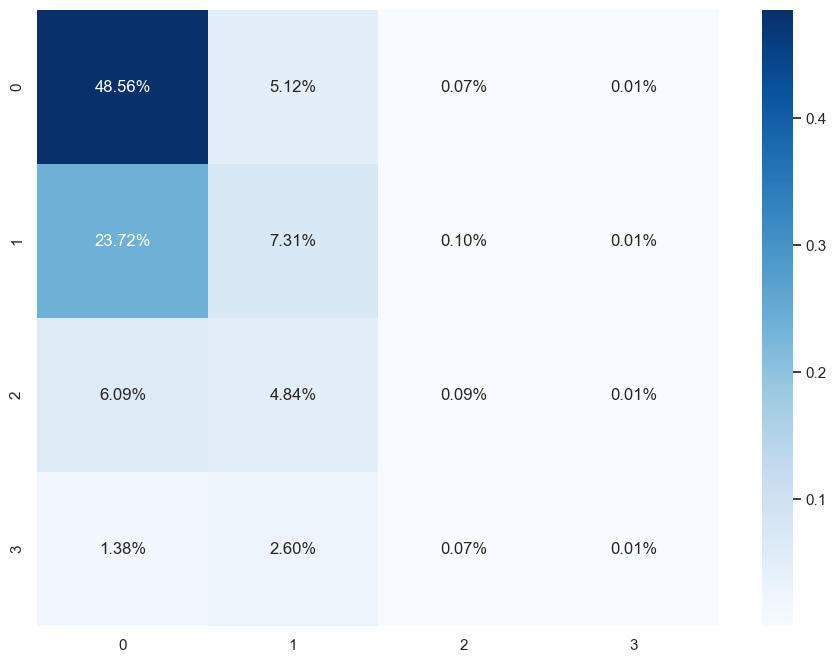

In [401]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

print('For binary prediction:')
print('F1 score: {0:0.4f}'. format(f1_score(y_test_bin, y_pred_bin)))
print('Precision score: {0:0.4f}'. format(precision_score(y_test_bin, y_pred_bin)))
print('Recall score: {0:0.4f}\n'. format(recall_score(y_test_bin, y_pred_bin)))

print('For multiclass prediction:  (... it\'s a little more complicated)')
cm = confusion_matrix(y_test_mul, y_pred_mul)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')

The binary classification model is slightly better with positive predictions than negative predictions, but precision and recall are pretty balanced, as exhibited by an f1 score that is less than 2% from each. Unfortunately, that means this classifier can't be trusted as exceptionally accurate in finding true positives or true negatives.<br>

The confusion matrix for the multiclass classification model shows clearly that the imbalanced classes are resulting in a bunch of false negatives. The model is overpredicting 0 chronic diseases, particularly for individuals with 1 or 2 chronic diseases, and it's overpredicting 1 chronic disease, particularly for individuals with 2 or 3 chronic disease. It's predicting >1 chronic disease less than .1% of the time when in reality this is over 10% of the population.

#### 3.4.2 XGBoost

In [402]:
import xgboost as xgb
from sklearn.metrics import classification_report

xgb1 = xgb.XGBClassifier()

# ------------------
# Train the model
# ------------------
xgb1.fit(X_train, y_train_bin)

# ------------------------------------
# Make predictions on the test set
# ------------------------------------
y_pred_xgb1 = xgb1.predict(X_test)

# ------------------------------------------------------------------------
# Evaluate the model using accuracy, precision, recall, and F1 score
# ------------------------------------------------------------------------

print('XGB:', accuracy_score(y_test_bin, y_pred_xgb1))
print('XGB:', precision_score(y_test_bin, y_pred_xgb1))
print('XGB:', recall_score(y_test_bin, y_pred_xgb1))
print('XGB:', f1_score(y_test_bin, y_pred_xgb1))

print(classification_report(y_test_bin, y_pred_xgb1))
# Confusion Matrix
pd.crosstab(y_pred_xgb1, y_test_bin, rownames =['y_pred_xgb'], colnames = ['y_test_bin'] )

XGB: 0.693835002850395
XGB: 0.6710047778649362
XGB: 0.662897601183557
XGB: 0.6669265526712147
              precision    recall  f1-score   support

           0       0.71      0.72      0.72     33006
           1       0.67      0.66      0.67     28389

    accuracy                           0.69     61395
   macro avg       0.69      0.69      0.69     61395
weighted avg       0.69      0.69      0.69     61395



y_test_bin,0,1
y_pred_xgb,,
0,23779,9570
1,9227,18819


##### Hyperparameter tuning for XGBoost CMB_binary

In [403]:
# ------------------
# Define the XGB model
# ------------------
xgb1 = xgb.XGBClassifier(n_estimators=1000,
                        max_depth = 15,
                        eta= 0.01,
                        min_child_weight = 5,
                        random_state=100)

# ------------------
# Train the model
# ------------------
xgb1.fit(X_train, y_train_bin)

# ------------------------------------
# Make predictions on the test set
# ------------------------------------
y_pred_xgb1 = xgb1.predict(X_test)

# ------------------------------------------------------------------------
# Evaluate the model using accuracy, precision, recall, and F1 score
# ------------------------------------------------------------------------

print('XGB:', accuracy_score(y_test_bin, y_pred_xgb1))
print('XGB:', precision_score(y_test_bin, y_pred_xgb1))
print('XGB:', recall_score(y_test_bin, y_pred_xgb1))
print('XGB:', f1_score(y_test_bin, y_pred_xgb1))

print(classification_report(y_test_bin, y_pred_xgb1))
# Confusion Matrix
pd.crosstab(y_pred_xgb1, y_test_bin, rownames =['y_pred_xgb'], colnames = ['y_test_bin'] )

XGB: 0.6868311751771317
XGB: 0.6641582455385938
XGB: 0.6528585015322836
XGB: 0.6584598987476685
              precision    recall  f1-score   support

           0       0.71      0.72      0.71     33006
           1       0.66      0.65      0.66     28389

    accuracy                           0.69     61395
   macro avg       0.68      0.68      0.68     61395
weighted avg       0.69      0.69      0.69     61395



y_test_bin,0,1
y_pred_xgb,,
0,23634,9855
1,9372,18534


In the XGBoost model to predict CMB_binary, we added more on n_estimators and max_depth, however, the model accuracy dropped from 0.69 to 0.68. That means parameter hyper tuning is not working well. We have also tried grid search, but using grid search to hyper tune this model would take too long to run the code.

##### XGBoost for CMB_multiclass

In [404]:
# ------------------
# Define the XGB model
# ------------------
xgb2 = xgb.XGBClassifier(n_estimators=100,
                        max_depth = 10,
                        eta= 0.01,
                        min_child_weight = 5,
                        random_state=100)

# ------------------
# Train the model
# ------------------
xgb2.fit(X_train, y_train_mul)

# ------------------------------------
# Make predictions on the test set
# ------------------------------------
y_pred_xgb2 = xgb2.predict(X_test)

# ------------------------------------------------------------------------
# Evaluate the model using accuracy, precision, recall, and F1 score
# ------------------------------------------------------------------------

print('XGB:', accuracy_score(y_test_mul, y_pred_xgb2))
print('XGB:', precision_score(y_test_mul, y_pred_xgb2, average='weighted'))
print('XGB:', recall_score(y_test_mul, y_pred_xgb2, average='weighted'))
print('XGB:', f1_score(y_test_mul, y_pred_xgb2, average='weighted'))

print(classification_report(y_test_mul, y_pred_xgb2))
# Confusion Matrix
pd.crosstab(y_pred_xgb2, y_test_mul, rownames =['y_pred_xgb'], colnames = ['y_test_mul'] )

XGB: 0.5744930368922551
XGB: 0.5244183483290692
XGB: 0.5744930368922551
XGB: 0.528328016565046
              precision    recall  f1-score   support

           0       0.65      0.85      0.74     33006
           1       0.41      0.35      0.38     19124
           2       0.31      0.06      0.10      6770
           3       0.37      0.08      0.14      2495

    accuracy                           0.57     61395
   macro avg       0.43      0.33      0.34     61395
weighted avg       0.52      0.57      0.53     61395



y_test_mul,0,1,2,3
y_pred_xgb,,,,
0,28011,11905,2740,532
1,4801,6667,3480,1449
2,141,421,387,308
3,53,131,163,206


XGB boost model for predicting CMB_multiclass only get an accuracy of 0.57 which is very low. For this model, we chose parameters where n_estimator = 100, max_depth = 10. Perhaps we can try a lager number for both parameters to get a better accuracy. But due to the consideration of time it would take(>10 min), we're going to leave that part.

#### 3.4.3 Random Forest

In [405]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

#### Baseline model for CMB_Binary

In [406]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train_bin)

# Evaluate the classifier on test set
y_pred = clf.predict(X_test)
print(classification_report(y_test_bin, y_pred))

confusion_matrix(y_test_bin, y_pred)

# Confusion matrix
pd.crosstab(y_pred, y_test_bin, rownames=['y_pred'], colnames = ['y_test'])

              precision    recall  f1-score   support

           0       0.68      0.70      0.69     33006
           1       0.64      0.62      0.63     28389

    accuracy                           0.66     61395
   macro avg       0.66      0.66      0.66     61395
weighted avg       0.66      0.66      0.66     61395



y_test,0,1
y_pred,,
0,23098,10694
1,9908,17695


#### Hypertuning the CMB_binary model

Choosing some of the hyperparameters:

n_estimators : Increasing num of trees can lead to better performance, but also increases training time and memory requirements.
criterion : Using "Entropy" sometimes result in better perfomance while dealing with unbalanced datasets.
min_samples_split : Increasing this value can reduce overfitting and also lead to underfitting.
min_samples_leaf : Increasing this value can lead to more generalized model that performs better on unseen data.

In [407]:
clf = RandomForestClassifier(n_estimators=1000,
                            criterion='entropy',
                            min_samples_split=5,
                            min_samples_leaf=5,
                            random_state=42)
clf.fit(X_train, y_train_bin)

# Evaluate the classifier on test set
y_pred = clf.predict(X_test)
print(classification_report(y_test_bin, y_pred))

confusion_matrix(y_test_bin, y_pred)

print('Hypertuned RF Accuracy for CMB_binary:', accuracy_score(y_test_bin, y_pred))

# Confusion matrix
pd.crosstab(y_pred, y_test_bin, rownames=['y_pred'], colnames = ['y_test'])

              precision    recall  f1-score   support

           0       0.71      0.72      0.72     33006
           1       0.67      0.66      0.66     28389

    accuracy                           0.69     61395
   macro avg       0.69      0.69      0.69     61395
weighted avg       0.69      0.69      0.69     61395

Hypertuned RF Accuracy for CMB_binary: 0.6927762847137389


y_test,0,1
y_pred,,
0,23875,9731
1,9131,18658


##### Comparing the performance metrics for CMB_binary

Before hypertuning the random forest model for the binary classification problem of CMB data, the model had an accuracy of 0.66 with precision and recall scores of 0.68 and 0.70 for class 0, and 0.64 and 0.62 for class 1, respectively. The F1-score was 0.69 for class 0 and 0.63 for class 1.

After hypertuning the model, the accuracy improved to 0.69 with precision and recall scores of 0.71 and 0.72 for class 0, and 0.67 and 0.66 for class 1, respectively. The F1-score improved to 0.72 for class 0 and 0.66 for class 1.

In general, the model's performance improved after hypertuning with higher accuracy, precision, recall, and F1-score for both classes. The precision and recall of both classes are now more balanced, indicating that the model is better at correctly identifying both classes.

#### Baseline model for CMB_multiclass

In [408]:
print(type(y_train_mul), type(y_test_mul))

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [409]:
y_train_mul.unique()

array([0, 1, 2, 3])

In [410]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train_mul)

# Evaluate the classifier on test set
y_pred = clf.predict(X_test)
print(classification_report(y_test_mul, y_pred))

confusion_matrix(y_test_mul, y_pred)

print('Baseline RF Accuracy for CMB_multi:', accuracy_score(y_test_bin, y_pred))

# Confusion matrix
pd.crosstab(y_pred, y_test_mul, rownames=['y_pred'], colnames = ['y_test'])

              precision    recall  f1-score   support

           0       0.64      0.77      0.70     33006
           1       0.39      0.35      0.37     19124
           2       0.24      0.13      0.17      6770
           3       0.25      0.10      0.15      2495

    accuracy                           0.54     61395
   macro avg       0.38      0.34      0.35     61395
weighted avg       0.50      0.54      0.52     61395

Baseline RF Accuracy for CMB_multi: 0.5870673507614627


y_test,0,1,2,3
y_pred,,,,
0,25309,10692,2684,591
1,6555,6744,2893,1097
2,956,1387,896,547
3,186,301,297,260


In [411]:
clf = RandomForestClassifier(n_estimators=1000,
                            criterion='entropy',
                            min_samples_split=10,
                            min_samples_leaf=5,
                            random_state=42)
clf.fit(X_train, y_train_mul)

# Evaluate the classifier on test set
y_pred = clf.predict(X_test)
print(classification_report(y_test_mul, y_pred))

confusion_matrix(y_test_mul, y_pred)

print('Hypertuned RF Accuracy for CMB_multi:', accuracy_score(y_test_bin, y_pred))
# Confusion matrix
pd.crosstab(y_pred, y_test_mul, rownames=['y_pred'], colnames = ['y_test'])

              precision    recall  f1-score   support

           0       0.65      0.84      0.73     33006
           1       0.41      0.35      0.38     19124
           2       0.31      0.07      0.12      6770
           3       0.41      0.06      0.11      2495

    accuracy                           0.57     61395
   macro avg       0.44      0.33      0.33     61395
weighted avg       0.53      0.57      0.53     61395

Hypertuned RF Accuracy for CMB_multi: 0.6424953172082417


y_test,0,1,2,3
y_pred,,,,
0,27849,11829,2689,535
1,4946,6721,3474,1402
2,191,495,486,403
3,20,79,121,155


##### Comparing the performance metrics for CMB_multiclass

Before hypertuning the random forest model, the accuracy was 0.5864, whereas after hypertuning, the accuracy improved to 0.6425. This indicates that the hypertuning of the random forest model has improved its performance.

Looking at the precision and recall scores for each class, we can see that class 0 (No Chronic Condition) has the highest precision and recall scores, followed by class 1 (One Chronic Condition). Class 2 (Two Chronic Conditions) and class 3 (Three or more Chronic Conditions) have lower precision and recall scores, indicating that the model struggles to accurately predict these classes.

Comparing the confusion matrix before and after hypertuning, we can see that the hypertuned model has a higher number of correct predictions (true positives) for each class compared to the baseline model. For example, for class 0, the hypertuned model has correctly predicted 27849 instances compared to 25376 instances in the baseline model. Similarly, for class 1, the hypertuned model has correctly predicted 6721 instances compared to 6666 instances in the baseline model.

In conclusion, the hypertuned random forest model has improved the accuracy and performance of the model in predicting the number of chronic conditions a person may have.

#### 3.4.4 Gradient Boosting

In [412]:
from sklearn.ensemble import GradientBoostingClassifier

##### Baseline Model for CMB_binary

In [413]:
clf = GradientBoostingClassifier()

clf.fit(X_train, y_train_bin)

# Evaluate the classifier on test set
y_pred = clf.predict(X_test)
print(classification_report(y_test_bin, y_pred))

confusion_matrix(y_test_bin, y_pred)

print('Baseline GB Accuracy for CMB_binary:', accuracy_score(y_test_bin, y_pred))

# Confusion matrix
pd.crosstab(y_pred, y_test_bin, rownames=['y_pred'], colnames = ['y_test'])

              precision    recall  f1-score   support

           0       0.71      0.73      0.72     33006
           1       0.68      0.66      0.67     28389

    accuracy                           0.70     61395
   macro avg       0.69      0.69      0.69     61395
weighted avg       0.70      0.70      0.70     61395

Baseline GB Accuracy for CMB_binary: 0.6955126638977115


y_test,0,1
y_pred,,
0,24010,9698
1,8996,18691


##### Hypertuning the model for CMB_binary

Choosing some of the parameters for tuning:

1. n_estimators : Increasing this value can improve the performance of the model with some risk of overfitting.
2. min_samples_split : Increasing this values can lead to more generalizable model that is less prone to overfitting
3. learning_rate : A smaller learning rate may lead to more accurate model but causes converging to be slow.
4. min_samples_leaf : Increasing this value can help prevent overfitting but a high value may lead to underfitting.

In [414]:
clf = GradientBoostingClassifier(n_estimators=1000,
                            min_samples_split=5,
                            learning_rate=0.5,
                            min_samples_leaf=5,
                            random_state=42)

clf.fit(X_train, y_train_bin)

# Evaluate the classifier on test set
y_pred = clf.predict(X_test)
print(classification_report(y_test_bin, y_pred))

confusion_matrix(y_test_bin, y_pred)

print('Hypertuned GB Accuracy for CMB_binary:', accuracy_score(y_test_bin, y_pred))

# Confusion matrix
pd.crosstab(y_pred, y_test_bin, rownames=['y_pred'], colnames = ['y_test'])

              precision    recall  f1-score   support

           0       0.71      0.72      0.72     33006
           1       0.67      0.66      0.67     28389

    accuracy                           0.69     61395
   macro avg       0.69      0.69      0.69     61395
weighted avg       0.69      0.69      0.69     61395

Hypertuned GB Accuracy for CMB_binary: 0.6944213698183891


y_test,0,1
y_pred,,
0,23879,9634
1,9127,18755


##### Comparing performance metrics for CMB_binary

The baseline gradient boosting model for the binary CMB classification problem had an accuracy of 0.696, with a precision of 0.68, recall of 0.66 and f1-score of 0.67 for class 1. After hypertuning the model, the accuracy decreased slightly to 0.694, with a precision of 0.67, recall of 0.66 and f1-score of 0.67 for class 1.

There were no significant improvements in performance after hypertuning the gradient boosting model.

However, the accuracy, precision, recall and f1-score for class 1 were all within a small range which indicates that the model was consistently predicting both classes with similar performance.

##### Baseline model for CMB_multiclass

In [415]:
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train_mul)

# Evaluate the classifier on test set
y_pred = clf.predict(X_test)
print(classification_report(y_test_mul, y_pred))

confusion_matrix(y_test_mul, y_pred)

print('Baseline GB Accuracy for CMB_multi:', accuracy_score(y_test_bin, y_pred))

# Confusion matrix
pd.crosstab(y_pred, y_test_mul, rownames=['y_pred'], colnames = ['y_test'])

              precision    recall  f1-score   support

           0       0.66      0.85      0.74     33006
           1       0.41      0.36      0.38     19124
           2       0.32      0.07      0.11      6770
           3       0.38      0.09      0.15      2495

    accuracy                           0.58     61395
   macro avg       0.44      0.34      0.35     61395
weighted avg       0.53      0.58      0.54     61395

Baseline GB Accuracy for CMB_multi: 0.6493525531395065


y_test,0,1,2,3
y_pred,,,,
0,28001,11702,2536,435
1,4803,6827,3581,1458
2,152,456,464,369
3,50,139,189,233


##### Hypertuned model for CMB_multi

In [416]:
clf = GradientBoostingClassifier(n_estimators=500,
                            min_samples_split=5,
                            learning_rate=0.5,
                            min_samples_leaf=5,
                            random_state=42)
clf.fit(X_train, y_train_mul)

# Evaluate the classifier on test set
y_pred = clf.predict(X_test)
print(classification_report(y_test_mul, y_pred))

confusion_matrix(y_test_mul, y_pred)

print('Hypertuned GB Accuracy for CMB_multi:', accuracy_score(y_test_bin, y_pred))
# Confusion matrix
pd.crosstab(y_pred, y_test_mul, rownames=['y_pred'], colnames = ['y_test'])

              precision    recall  f1-score   support

           0       0.66      0.83      0.74     33006
           1       0.42      0.37      0.39     19124
           2       0.32      0.09      0.15      6770
           3       0.36      0.11      0.17      2495

    accuracy                           0.58     61395
   macro avg       0.44      0.35      0.36     61395
weighted avg       0.53      0.58      0.54     61395

Hypertuned GB Accuracy for CMB_multi: 0.6417949344409154


y_test,0,1,2,3
y_pred,,,,
0,27512,11182,2426,438
1,5173,7101,3472,1318
2,256,652,638,469
3,65,189,234,270


##### Comparing performance metrics for CMB_multiclass
The baseline multiclass gradient boosting (GB) model had an accuracy of 0.649, while the hypertuned GB model had an accuracy of 0.642. The hypertuned model's accuracy is slightly lower.

Looking at the precision, recall, and f1-score for each class, we can see that the scores for the hypertuned model are similar to those of the baseline model. This suggests that the model hasn't improved much in terms of its ability to correctly identify each class.

In terms of the confusion matrix, we can see that for class 0, the hypertuned model has a slightly lower number of correct predictions compared to the baseline model, while for classes 1, 2, and 3, the hypertuned model has a slightly higher number of correct predictions. This suggests that the hypertuned model may be slightly better at predicting the minority classes, but not significantly.

Overall, the hypertuned model didn't show a significant improvement over the baseline model.

#### 3.4.5 KNN

##### KNN for CMB_binary

In [417]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import sklearn

# KNN classifier with 5 neighbors
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train_bin)

# Make predictions on the testing set
y_pred = knn_clf.predict(X_test)

# print the various classification metrics
print(f"Overall accuracy is {sklearn.metrics.accuracy_score(y_pred, y_test_bin)}")
print(f"Model r2 score is {knn_clf.score(X_test, y_test_bin)}")
print(f"Precision or TP/(TP + FP) is {sklearn.metrics.precision_score(y_pred, y_test_bin)}")
print(f"Recall or TP / (TP + FN) is {sklearn.metrics.recall_score(y_pred, y_test_bin)}")
print(f"F1-score or 2*Precision*Recall / (Precision + Recall)  is {sklearn.metrics.f1_score(y_pred, y_test_bin)}")
print(f"Confusion Matrix \n{sklearn.metrics.confusion_matrix(y_pred, y_test_bin)}")

Overall accuracy is 0.6438472188288948
Model r2 score is 0.6438472188288948
Precision or TP/(TP + FP) is 0.5892775370742189
Recall or TP / (TP + FN) is 0.6210878039725265
F1-score or 2*Precision*Recall / (Precision + Recall)  is 0.6047646590991252
Confusion Matrix 
[[22800 11660]
 [10206 16729]]


Using KNN to predict CMB_binary took 13 minutes and the model accuracy is 0.64, which is lower than the model accuracy from XGBoost. And considering the time taken for the model where we only use n_neighbors = 5, hyper tuning would consume much more time and not worth it for this model.

##### KNN for CMB_multiclass

In [418]:
# KNN classifier with 5 neighbors
knn_clf2 = KNeighborsClassifier(n_neighbors=5)
knn_clf2.fit(X_train, y_train_mul)

# Make predictions on the testing set
y_pred2 = knn_clf2.predict(X_test)

# print the various classification metrics
print(f"Overall accuracy is {sklearn.metrics.accuracy_score(y_pred2, y_test_mul)}")
print(f"Model r2 score is {knn_clf2.score(X_test, y_test_mul)}")
print(f"Precision or TP/(TP + FP) is {sklearn.metrics.precision_score(y_pred2, y_test_mul, average='weighted')}")
print(f"Recall or TP / (TP + FN) is {sklearn.metrics.recall_score(y_pred2, y_test_mul, average='weighted')}")
print(f"F1-score or 2*Precision*Recall / (Precision + Recall)  is {sklearn.metrics.f1_score(y_pred2, y_test_mul, average='weighted')}")
print(f"Confusion Matrix \n{sklearn.metrics.confusion_matrix(y_pred2, y_test_mul)}")

Overall accuracy is 0.5339522762439938
Model r2 score is 0.5339522762439938
Precision or TP/(TP + FP) is 0.62807266505383
Recall or TP / (TP + FN) is 0.5339522762439938
F1-score or 2*Precision*Recall / (Precision + Recall)  is 0.5706985644837601
Confusion Matrix 
[[26052 12050  3330   921]
 [ 6206  5878  2567  1003]
 [  626   957   691   410]
 [  122   239   182   161]]


The model accuracy from KNN for the CMB_multiclass is 0.53. And it took 8 minutes to run this simple model. Grid Search would take way more time and since the model accuracy is relatively low compared to other models, we're not doing hyper parameter tuning for this model.

#### 3.4.6 Catboost Classification

0:	learn: 0.6900544	test: 0.6901333	best: 0.6901333 (0)	total: 6.21ms	remaining: 24.8ms
1:	learn: 0.6871318	test: 0.6872773	best: 0.6872773 (1)	total: 13.7ms	remaining: 20.5ms
2:	learn: 0.6843712	test: 0.6845675	best: 0.6845675 (2)	total: 20.4ms	remaining: 13.6ms
3:	learn: 0.6816991	test: 0.6819641	best: 0.6819641 (3)	total: 26.7ms	remaining: 6.67ms
4:	learn: 0.6791812	test: 0.6794929	best: 0.6794929 (4)	total: 36.4ms	remaining: 0us

bestTest = 0.6794928823
bestIteration = 4

0:	loss: 0.6794929	best: 0.6794929 (0)	total: 116ms	remaining: 12.4s
0:	learn: 0.6813174	test: 0.6816059	best: 0.6816059 (0)	total: 7.59ms	remaining: 30.4ms
1:	learn: 0.6715673	test: 0.6720494	best: 0.6720494 (1)	total: 13.9ms	remaining: 20.8ms
2:	learn: 0.6635596	test: 0.6640805	best: 0.6640805 (2)	total: 21.4ms	remaining: 14.3ms
3:	learn: 0.6558619	test: 0.6565144	best: 0.6565144 (3)	total: 28ms	remaining: 6.99ms
4:	learn: 0.6498322	test: 0.6505465	best: 0.6505465 (4)	total: 35.2ms	remaining: 0us

bestTest = 0.6

<AxesSubplot: >

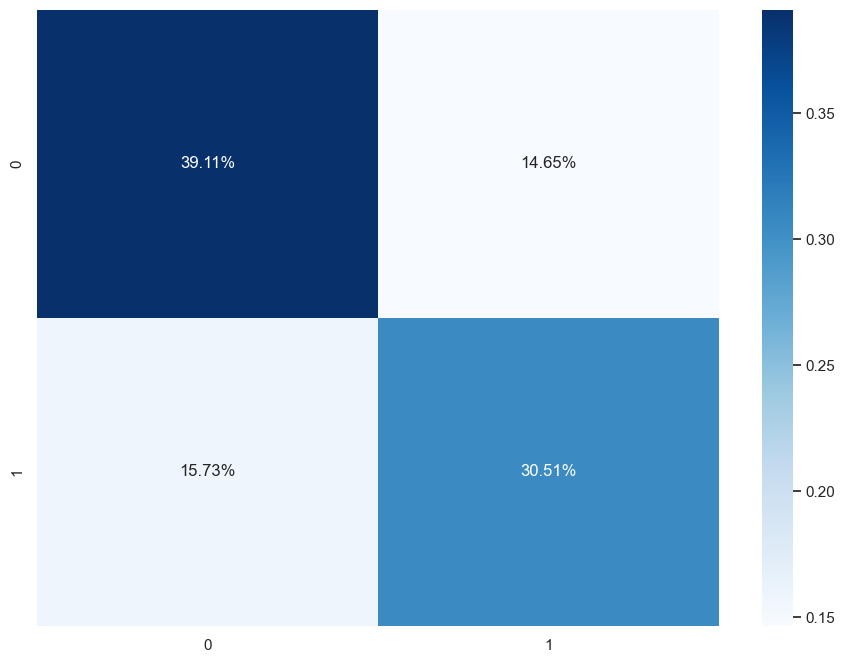

In [419]:
import catboost as cb

# Logloss is cost function used in catboost.ai's quick start guide
cb_model_bin = cb.CatBoostClassifier(loss_function='Logloss')
cb_model_mul = cb.CatBoostClassifier(loss_function='Logloss')

# Properly pool the datasets
train_dataset_bin = cb.Pool(X_train, y_train_bin)
test_dataset_bin = cb.Pool(X_test, y_test_bin)
train_dataset_mul = cb.Pool(X_train, y_train_mul)
test_dataset_mul = cb.Pool(X_test, y_test_mul)

# Hyperparameter tuning
grid = {'iterations': [5, 50, 150],
        'learning_rate': [0.025, 0.1, 0.25],
        'depth': [2, 4, 6],
        'l2_leaf_reg': [0.25, 0.5, 1, 2]}
cb_model_bin.grid_search(grid, train_dataset_bin)
#cb_model_mul.grid_search(grid, train_dataset_mul)
# Didn't work. Expected binary.

#cb_model_mul.fit(train_dataset_mul)

# Make predictions
cb_pred_bin = cb_model_bin.predict(X_test)
#cb_pred_mul = cb_model_mul.predict(X_test)

# How did we do?
print('Binary confusion matrix:')
cb_cm_bin = confusion_matrix(y_test_bin, cb_pred_bin)
sns.heatmap(cb_cm_bin/np.sum(cb_cm_bin), annot=True, fmt='.2%', cmap='Blues')

With accuracy around 70% and again a balance between precision and recall, this catboost model isn't strong enough to use in a clinical setting. It performs similarly to the most simple of our models, logistic classification.

0:	learn: 1.3664108	test: 1.3665144	best: 1.3665144 (0)	total: 19.8ms	remaining: 79.2ms
1:	learn: 1.3477800	test: 1.3479579	best: 1.3479579 (1)	total: 44.3ms	remaining: 66.5ms
2:	learn: 1.3304453	test: 1.3307076	best: 1.3307076 (2)	total: 65ms	remaining: 43.3ms
3:	learn: 1.3142570	test: 1.3145879	best: 1.3145879 (3)	total: 86.2ms	remaining: 21.6ms
4:	learn: 1.2989587	test: 1.2993482	best: 1.2993482 (4)	total: 106ms	remaining: 0us

bestTest = 1.2993482
bestIteration = 4

0:	loss: 1.2993482	best: 1.2993482 (0)	total: 192ms	remaining: 1.35s
0:	learn: 1.3098753	test: 1.3102810	best: 1.3102810 (0)	total: 20.6ms	remaining: 82.3ms
1:	learn: 1.2513779	test: 1.2519031	best: 1.2519031 (1)	total: 41.9ms	remaining: 62.9ms
2:	learn: 1.2052435	test: 1.2059428	best: 1.2059428 (2)	total: 62.5ms	remaining: 41.7ms
3:	learn: 1.1671562	test: 1.1678832	best: 1.1678832 (3)	total: 86ms	remaining: 21.5ms
4:	learn: 1.1360552	test: 1.1368554	best: 1.1368554 (4)	total: 106ms	remaining: 0us

bestTest = 1.13685542

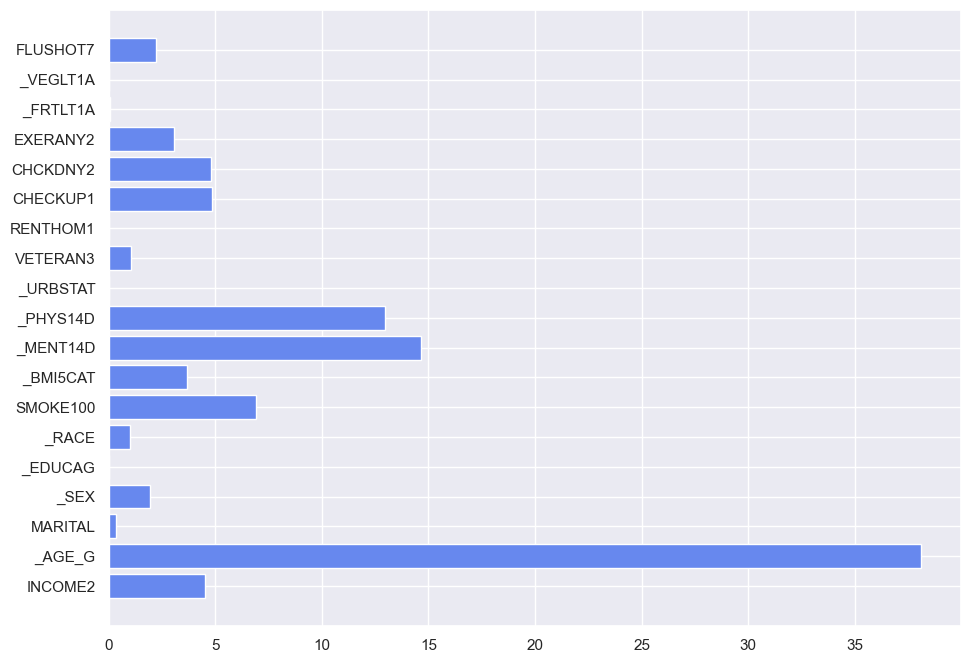

Accuracy 0.5762684257675706


In [420]:
# Step 1: Initialise and fit CatBoost multiclass model
cb_model_mul = cb.CatBoostClassifier(loss_function='MultiClass', 
                           max_depth=4,  
                           random_seed=42)

# Hyperparameter tuning
grid = {'iterations': [5, 50],
        'learning_rate': [0.025, 0.1],
        'l2_leaf_reg': [0.25, 0.5]}
cb_model_mul.grid_search(grid, train_dataset_mul)
#model.fit(X_train, y_train_mul, verbose=False)

# Step 2: Plot feature importances
features = X_train.columns
importance_values = cb_model_mul.feature_importances_

plt.barh(y=range(len(features)),
         width=importance_values,
         tick_label=features)
plt.show()

# Step 3: Make predictions for test data & evaluate performance
y_pred_mul = cb_model_mul.predict(X_test)
print('Accuracy',accuracy_score(y_test_mul, y_pred_mul))


Multiclass confusion matrix:


<AxesSubplot: >

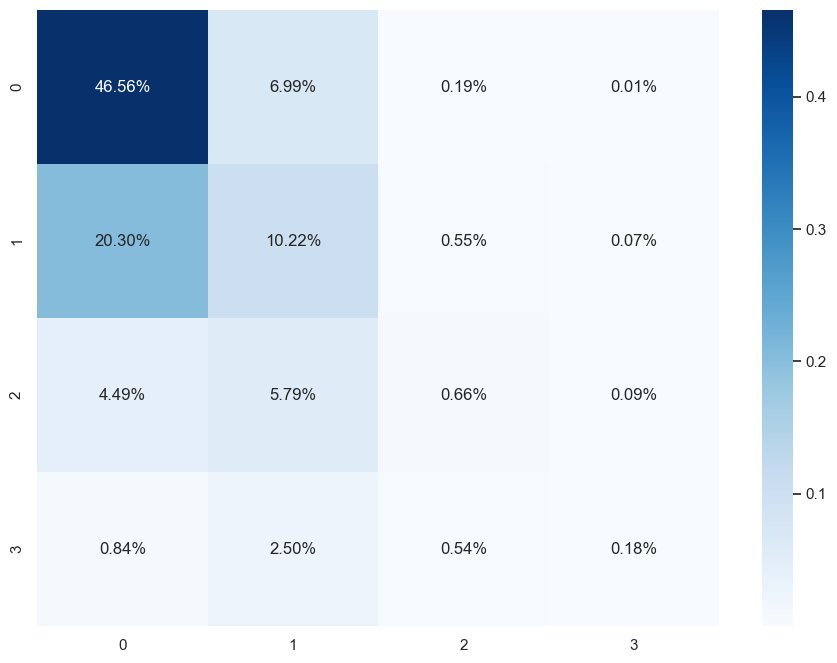

In [421]:
print('Multiclass confusion matrix:')
cb_cm_mul = confusion_matrix(y_test_mul, y_pred_mul)
sns.heatmap(cb_cm_mul/np.sum(cb_cm_mul), annot=True, fmt='.2%', cmap='Blues')

Remarkably, accuracy is not much better than logistic classification at 57.6% for multiclass classification with catboost vs 56% with logistic regression. As we can see with the importance values, age is by far the most predictive of all the features we considered. The next nearest is mental health in the prior 14 days with 1/3rd the predictive power.